In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec
import time

In [2]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [3]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

# Surface

### hfls - surface upward latent heat flux

In [4]:
df_hfls_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfls' & experiment_id == 'piControl'")
df_hfls_control = df_hfls_control.drop_duplicates('source_id').head(23)
df_hfls_control = df_hfls_control.drop(index=55602)
df_hfls_control = df_hfls_control.drop(index=66920)
df_hfls_control = df_hfls_control.drop(index=67580)
df_hfls_control = df_hfls_control.drop(index=67682)
df_hfls_control = df_hfls_control.drop(index=75904)
df_hfls_control = df_hfls_control.drop(index=206285)
df_hfls_control = df_hfls_control.drop(index=209092)
df_hfls_control = df_hfls_control.drop(index=217594)
df_hfls_control = df_hfls_control.drop(index=236089)
df_hfls_control = df_hfls_control.drop(index=237861)
df_hfls_control

activity_id     institution_id        source_id experiment_id  \
9283          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18360         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31844         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32241         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40387         CMIP                BCC      BCC-CSM2-MR     piControl   
42768         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44318         CMIP              MIROC           MIROC6     piControl   
44787         CMIP                BCC         BCC-ESM1     piControl   
88423         CMIP              CCCma    CanESM5-CanOE     piControl   
89845         CMIP              CCCma          CanESM5     piControl   
211550        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213494        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243298        CMIP       E3SM-Project         E3SM-1-0     piControl   

       member_id table_id variable_id grid_label  \
9283    r1i1p1f1     Amon        hfls        gr1   
18360   r1i1p1f1     Amon        hfls        gr1   
31844   r1i1p1f2     Amon        hfls         gr   
32241   r1i1p1f1     Amon        hfls         gn   
40387   r1i1p1f1     Amon        hfls         gn   
42768   r1i1p1f2     Amon        hfls         gr   
44318   r1i1p1f1     Amon        hfls         gn   
44787   r1i1p1f1     Amon        hfls         gn   
88423   r1i1p2f1     Amon        hfls         gn   
89845   r1i1p1f1     Amon        hfls         gn   
211550  r1i1p1f1     Amon        hfls         gn   
213494  r1i1p1f1     Amon        hfls         gn   
243298  r1i1p1f1     Amon        hfls         gr   

                                                   zstore  dcpp_init_year  \
9283    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18360   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31844   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32241   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40387   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42768   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44318   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
44787   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
88423   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89845   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211550  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213494  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243298  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
9283    20180701  
18360   20180701  
31844   20180814  
32241   20180824  
40387   20181016  
42768   20181115  
44318   20181212  
44787   20181214  
88423   20190429  
89845   20190429  
211550  20190627  
213494  20190628  
243298  20190719

In [5]:
df_hfls_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfls' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_hfls_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429229        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429229     Amon        hfls         gr   

                                                   zstore  dcpp_init_year  \
429229  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429229  20200326

In [6]:
df_hfls_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfls' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_hfls_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254938        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254938        hfls         gn   

                                                   zstore  dcpp_init_year  \
254938  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254938  20190818

In [7]:
df_hfls_control = df_hfls_control.append(df_hfls_IPSL)
df_hfls_control = df_hfls_control.append(df_hfls_FGOALS)
df_hfls_control

/tmp/ipykernel_20376/890973110.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hfls_control = df_hfls_control.append(df_hfls_IPSL)
/tmp/ipykernel_20376/890973110.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hfls_control = df_hfls_control.append(df_hfls_FGOALS)


activity_id     institution_id        source_id experiment_id  \
9283          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18360         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31844         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32241         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40387         CMIP                BCC      BCC-CSM2-MR     piControl   
42768         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44318         CMIP              MIROC           MIROC6     piControl   
44787         CMIP                BCC         BCC-ESM1     piControl   
88423         CMIP              CCCma    CanESM5-CanOE     piControl   
89845         CMIP              CCCma          CanESM5     piControl   
211550        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213494        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243298        CMIP       E3SM-Project         E3SM-1-0     piControl   
429229        CMIP               IPSL     IPSL-CM6A-LR     piControl   
254938        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9283    r1i1p1f1     Amon        hfls        gr1   
18360   r1i1p1f1     Amon        hfls        gr1   
31844   r1i1p1f2     Amon        hfls         gr   
32241   r1i1p1f1     Amon        hfls         gn   
40387   r1i1p1f1     Amon        hfls         gn   
42768   r1i1p1f2     Amon        hfls         gr   
44318   r1i1p1f1     Amon        hfls         gn   
44787   r1i1p1f1     Amon        hfls         gn   
88423   r1i1p2f1     Amon        hfls         gn   
89845   r1i1p1f1     Amon        hfls         gn   
211550  r1i1p1f1     Amon        hfls         gn   
213494  r1i1p1f1     Amon        hfls         gn   
243298  r1i1p1f1     Amon        hfls         gr   
429229  r1i1p1f1     Amon        hfls         gr   
254938  r1i1p1f1     Amon        hfls         gn   

                                                   zstore  dcpp_init_year  \
9283    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18360   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31844   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32241   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40387   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42768   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44318   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
44787   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
88423   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89845   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211550  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213494  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243298  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
429229  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
254938  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9283    20180701  
18360   20180701  
31844   20180814  
32241   20180824  
40387   20181016  
42768   20181115  
44318   20181212  
44787   20181214  
88423   20190429  
89845   20190429  
211550  20190627  
213494  20190628  
243298  20190719  
429229  20200326  
254938  20190818

In [8]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_hfls = []
for zstore in df_hfls_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_hfls_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_hfls = ds_hfls_interp.hfls
    ds_hfls['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfls.append(ds_hfls)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


BCC-ESM1
CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-g3


In [9]:
hfls_control = xr.concat(dset_list_hfls, dim='name', coords='minimal', compat='override')
hfls_control.load()

<xarray.DataArray 'hfls' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[ 2.38547093e-01,  2.17169947e-01,  1.97860759e-01, ...,
           3.27214617e-01,  3.04587983e-01,  2.82249742e-01],
         [ 5.87681115e-01,  4.65846276e-01,  3.82963084e-01, ...,
           8.75337571e-01,  8.00308540e-01,  7.25746143e-01],
         [ 7.42495206e-01,  6.34835795e-01,  5.03636003e-01, ...,
           1.22648113e+00,  1.09944874e+00,  9.74228024e-01],
         ...,
         [ 1.27182037e+00,  1.39327732e+00,  1.50449961e+00, ...,
           6.74753779e-01,  7.17430577e-01,  7.75793126e-01],
         [ 8.22045535e-01,  8.83573750e-01,  9.12409961e-01, ...,
           6.20048925e-01,  6.55825496e-01,  6.91396168e-01],
         [ 4.90021889e-01,  5.04518245e-01,  5.20845674e-01, ...,
           4.32110302e-01,  4.46577251e-01,  4.61051154e-01]],

        [[-2.26794026e-01, -2.33226196e-01, -2.39570290e-01, ...,
          -2.00464521e-01, -2.07133856e-01, -2.13748806e-01],
         [-2.73801447e-01, -2.58842283e-01, -2.55289897e-01, ...,
          -2.41962495e-01, -2.54068702e-01, -2.66142856e-01],
         [-3.11603542e-01, -3.20740463e-01, -3.26544225e-01, ...,
          -1.98796627e-01, -2.23665398e-01, -2.50819424e-01],
...
         [ 5.92432962e-01,  7.02190782e-01,  8.35018153e-01, ...,
           8.04039055e-01,  6.59394194e-01,  5.51772125e-01],
         [ 6.62035891e-01,  7.06319694e-01,  7.51108752e-01, ...,
           6.74078893e-01,  6.59312286e-01,  6.47623817e-01],
         [ 5.01883834e-01,  5.28594026e-01,  5.55586222e-01, ...,
           5.23542351e-01,  5.08651005e-01,  4.97059947e-01]],

        [[ 3.80851172e-01,  4.26474230e-01,  3.35117783e-01, ...,
           5.19808781e-01,  5.90354009e-01,  4.77513308e-01],
         [ 5.70886450e-01,  6.46879356e-01,  4.94631677e-01, ...,
           8.02452810e-01,  9.19997252e-01,  7.31943420e-01],
         [ 1.15466217e+00,  1.13830857e+00,  9.56576591e-01, ...,
           1.28233694e+00,  1.23951050e+00,  1.05822886e+00],
         ...,
         [ 5.07904357e-01,  5.09651536e-01,  5.41255495e-01, ...,
           8.13577703e-01,  6.08399738e-01,  5.38549830e-01],
         [ 5.54206540e-01,  5.01906514e-01,  4.63518012e-01, ...,
           7.47695085e-01,  6.50149501e-01,  6.43487698e-01],
         [ 4.14914387e-01,  3.82818127e-01,  3.59492736e-01, ...,
           5.30603454e-01,  4.72903613e-01,  4.69637594e-01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'IPSL-CM6A-LR' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Lv*evap
    interp_method:  conserve_order2
    long_name:      Surface Upward Latent Heat Flux
    original_name:  hfls
    standard_name:  surface_upward_latent_heat_flux
    units:          W m-2

In [10]:
hfls_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_hfls_piControl_2x2_250yr.nc')

### hfss - surface upward sensible heat flux

In [10]:
df_hfss_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl'")
df_hfss_control = df_hfss_control.drop_duplicates('source_id').head(8)
df_hfss_control

activity_id institution_id    source_id experiment_id member_id  \
9282         CMIP      NOAA-GFDL     GFDL-CM4     piControl  r1i1p1f1   
18358        CMIP      NOAA-GFDL    GFDL-ESM4     piControl  r1i1p1f1   
31857        CMIP   CNRM-CERFACS   CNRM-CM6-1     piControl  r1i1p1f2   
32262        CMIP      NASA-GISS  GISS-E2-1-G     piControl  r1i1p1f1   
40388        CMIP            BCC  BCC-CSM2-MR     piControl  r1i1p1f1   
42752        CMIP   CNRM-CERFACS  CNRM-ESM2-1     piControl  r1i1p1f2   
44319        CMIP          MIROC       MIROC6     piControl  r1i1p1f1   
44812        CMIP            BCC     BCC-ESM1     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9282      Amon        hfss        gr1   
18358     Amon        hfss        gr1   
31857     Amon        hfss         gr   
32262     Amon        hfss         gn   
40388     Amon        hfss         gn   
42752     Amon        hfss         gr   
44319     Amon        hfss         gn   
44812     Amon        hfss         gn   

                                                  zstore  dcpp_init_year  \
9282   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18358  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31857  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32262  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40388  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42752  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44319  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
44812  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   

        version  
9282   20180701  
18358  20180701  
31857  20180814  
32262  20180824  
40388  20181016  
42752  20181115  
44319  20181212  
44812  20181214

In [11]:
df_hfss_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_hfss_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429196        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429196     Amon        hfss         gr   

                                                   zstore  dcpp_init_year  \
429196  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429196  20200326

In [12]:
df_hfss_CanOE = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
df_hfss_CanOE

activity_id institution_id      source_id experiment_id member_id  \
88638        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   

      table_id variable_id grid_label  \
88638     Amon        hfss         gn   

                                                  zstore  dcpp_init_year  \
88638  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   

        version  
88638  20190429

In [13]:
df_hfss_CanESM5 = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
df_hfss_CanESM5

activity_id institution_id source_id experiment_id member_id table_id  \
89820        CMIP          CCCma   CanESM5     piControl  r1i1p1f1     Amon   

      variable_id grid_label  \
89820        hfss         gn   

                                                  zstore  dcpp_init_year  \
89820  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
89820  20190429

In [14]:
df_hfss_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_hfss_MPIESM

activity_id     institution_id        source_id experiment_id  \
211551        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
211551  r1i1p1f1     Amon        hfss         gn   

                                                   zstore  dcpp_init_year  \
211551  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
211551  20190627

In [15]:
df_hfss_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_hfss_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
213493        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
213493     Amon        hfss         gn   

                                                   zstore  dcpp_init_year  \
213493  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
213493  20190628

In [16]:
df_hfss_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_hfss_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243307        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243307        hfss         gr   

                                                   zstore  dcpp_init_year  \
243307  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243307  20190719

In [17]:
df_hfss_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_hfss_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254939        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254939        hfss         gn   

                                                   zstore  dcpp_init_year  \
254939  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254939  20190818

In [18]:
df_hfss_control = df_hfss_control.append(df_hfss_IPSL)
df_hfss_control = df_hfss_control.append(df_hfss_CanOE)
df_hfss_control = df_hfss_control.append(df_hfss_CanESM5)
df_hfss_control = df_hfss_control.append(df_hfss_MPIESM)
df_hfss_control = df_hfss_control.append(df_hfss_HadGEM)
df_hfss_control = df_hfss_control.append(df_hfss_E3SM)
df_hfss_control = df_hfss_control.append(df_hfss_FGOALS)
df_hfss_control

/tmp/ipykernel_20376/459962642.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hfss_control = df_hfss_control.append(df_hfss_IPSL)
/tmp/ipykernel_20376/459962642.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hfss_control = df_hfss_control.append(df_hfss_CanOE)
/tmp/ipykernel_20376/459962642.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hfss_control = df_hfss_control.append(df_hfss_CanESM5)
/tmp/ipykernel_20376/459962642.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hfss_control = df_hfss_control.append(df_hfss_MPIESM)
/tmp/ipykernel_20376/459962642.py:5: FutureWarning: The frame.append method is depreca

activity_id     institution_id        source_id experiment_id  \
9282          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18358         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31857         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32262         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40388         CMIP                BCC      BCC-CSM2-MR     piControl   
42752         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44319         CMIP              MIROC           MIROC6     piControl   
44812         CMIP                BCC         BCC-ESM1     piControl   
429196        CMIP               IPSL     IPSL-CM6A-LR     piControl   
88638         CMIP              CCCma    CanESM5-CanOE     piControl   
89820         CMIP              CCCma          CanESM5     piControl   
211551        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213493        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243307        CMIP       E3SM-Project         E3SM-1-0     piControl   
254939        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9282    r1i1p1f1     Amon        hfss        gr1   
18358   r1i1p1f1     Amon        hfss        gr1   
31857   r1i1p1f2     Amon        hfss         gr   
32262   r1i1p1f1     Amon        hfss         gn   
40388   r1i1p1f1     Amon        hfss         gn   
42752   r1i1p1f2     Amon        hfss         gr   
44319   r1i1p1f1     Amon        hfss         gn   
44812   r1i1p1f1     Amon        hfss         gn   
429196  r1i1p1f1     Amon        hfss         gr   
88638   r1i1p2f1     Amon        hfss         gn   
89820   r1i1p1f1     Amon        hfss         gn   
211551  r1i1p1f1     Amon        hfss         gn   
213493  r1i1p1f1     Amon        hfss         gn   
243307  r1i1p1f1     Amon        hfss         gr   
254939  r1i1p1f1     Amon        hfss         gn   

                                                   zstore  dcpp_init_year  \
9282    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18358   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31857   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32262   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40388   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42752   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44319   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
44812   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
429196  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
88638   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89820   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211551  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213493  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243307  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
254939  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9282    20180701  
18358   20180701  
31857   20180814  
32262   20180824  
40388   20181016  
42752   20181115  
44319   20181212  
44812   20181214  
429196  20200326  
88638   20190429  
89820   20190429  
211551  20190627  
213493  20190628  
243307  20190719  
254939  20190818

In [19]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_hfss = []
for zstore in df_hfss_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_hfss_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_hfss = ds_hfss_interp.hfss
    ds_hfss['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfss.append(ds_hfss)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


BCC-ESM1
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
FGOALS-g3


In [20]:
hfss_control = xr.concat(dset_list_hfss, dim='name', coords='minimal', compat='override')
hfss_control.load()

<xarray.DataArray 'hfss' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[-5.74673219e+00, -5.70053458e+00, -5.65229797e+00, ...,
          -5.93602426e+00, -5.88804471e+00, -5.84047744e+00],
         [-3.93807763e+00, -3.94646767e+00, -3.99771768e+00, ...,
          -4.57770543e+00, -4.45234442e+00, -4.32767005e+00],
         [-4.32478690e+00, -4.30310044e+00, -4.29768127e+00, ...,
          -4.80742502e+00, -4.81413043e+00, -4.80559206e+00],
         ...,
         [ 3.32729007e+00,  4.43598882e+00,  5.52067268e+00, ...,
          -3.05044085e+00, -2.28331608e+00, -1.38345377e+00],
         [ 8.47550362e-01,  1.56819419e+00,  1.87731993e+00, ...,
          -1.77590688e+00, -1.23365662e+00, -6.94880873e-01],
         [-2.20000497e+00, -2.03721382e+00, -1.86010763e+00, ...,
          -2.86236141e+00, -2.69514316e+00, -2.52894700e+00]],

        [[-1.56033368e+01, -1.54717677e+01, -1.53765345e+01, ...,
          -1.61508094e+01, -1.60108383e+01, -1.58728196e+01],
         [-1.45254930e+01, -1.38272671e+01, -1.37208397e+01, ...,
          -1.71394755e+01, -1.65426478e+01, -1.59500905e+01],
         [-1.58712500e+01, -1.54853805e+01, -1.49845562e+01, ...,
          -1.77813064e+01, -1.71935034e+01, -1.66486252e+01],
...
         [-1.18334985e+01, -1.12987398e+01, -1.04675364e+01, ...,
          -1.13945013e+01, -1.16321690e+01, -1.18979120e+01],
         [-1.11399252e+01, -1.09385409e+01, -1.06846964e+01, ...,
          -1.07608932e+01, -1.04793600e+01, -1.05846169e+01],
         [-8.81773133e+00, -8.65510388e+00, -8.46133312e+00, ...,
          -8.58461923e+00, -8.44029198e+00, -8.51687549e+00]],

        [[-3.61679214e+00, -3.33176744e+00, -3.77354248e+00, ...,
          -3.31572464e+00, -2.93872671e+00, -3.50179944e+00],
         [-5.95126585e+00, -5.47647252e+00, -6.21270242e+00, ...,
          -5.44964481e+00, -4.82148169e+00, -5.75985586e+00],
         [-5.90547984e+00, -5.98902890e+00, -6.48952778e+00, ...,
          -5.73252665e+00, -5.45682131e+00, -6.54607884e+00],
         ...,
         [-1.07394256e+01, -1.03956082e+01, -9.74270198e+00, ...,
          -9.48621147e+00, -9.96928324e+00, -1.02904866e+01],
         [-1.01222348e+01, -1.00484752e+01, -9.86881442e+00, ...,
          -8.85769340e+00, -8.62108992e+00, -8.76683050e+00],
         [-7.25172568e+00, -7.19648682e+00, -7.08760602e+00, ...,
          -6.55471042e+00, -6.40803251e+00, -6.49088587e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'E3SM-1-0' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Upward Sensible Heat Flux
    original_name:  hfss
    standard_name:  surface_upward_sensible_heat_flux
    units:          W m-2

In [22]:
hfss_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_hfss_piControl_2x2_250yr.nc')

### rlds - surface downwelling longwave flux

In [21]:
df_rlds_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl'")
df_rlds_control = df_rlds_control.drop_duplicates('source_id').head(10)
df_rlds_control = df_rlds_control.drop(index=55639)
df_rlds_control = df_rlds_control.drop(index=45956)
df_rlds_control

activity_id institution_id    source_id experiment_id member_id  \
9353         CMIP      NOAA-GFDL     GFDL-CM4     piControl  r1i1p1f1   
18475        CMIP      NOAA-GFDL    GFDL-ESM4     piControl  r1i1p1f1   
31920        CMIP   CNRM-CERFACS   CNRM-CM6-1     piControl  r1i1p1f2   
32240        CMIP      NASA-GISS  GISS-E2-1-G     piControl  r1i1p1f1   
40399        CMIP            BCC  BCC-CSM2-MR     piControl  r1i1p1f1   
42807        CMIP   CNRM-CERFACS  CNRM-ESM2-1     piControl  r1i1p1f2   
44788        CMIP            BCC     BCC-ESM1     piControl  r1i1p1f1   
65223        CMIP          MIROC       MIROC6     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9353      Amon        rlds        gr1   
18475     Amon        rlds        gr1   
31920     Amon        rlds         gr   
32240     Amon        rlds         gn   
40399     Amon        rlds         gn   
42807     Amon        rlds         gr   
44788     Amon        rlds         gn   
65223     Amon        rlds         gn   

                                                  zstore  dcpp_init_year  \
9353   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18475  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31920  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32240  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40399  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42807  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44788  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65223  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   

        version  
9353   20180701  
18475  20180701  
31920  20180814  
32240  20180824  
40399  20181016  
42807  20181115  
44788  20181214  
65223  20190311

In [22]:
df_rlds_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rlds_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429108        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429108     Amon        rlds         gr   

                                                   zstore  dcpp_init_year  \
429108  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429108  20200326

In [23]:
df_rlds_CanOE = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
df_rlds_CanOE

activity_id institution_id      source_id experiment_id member_id  \
88836        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   

      table_id variable_id grid_label  \
88836     Amon        rlds         gn   

                                                  zstore  dcpp_init_year  \
88836  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   

        version  
88836  20190429

In [24]:
df_rlds_CanESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
df_rlds_CanESM

activity_id institution_id source_id experiment_id member_id table_id  \
89889        CMIP          CCCma   CanESM5     piControl  r1i1p1f1     Amon   

      variable_id grid_label  \
89889        rlds         gn   

                                                  zstore  dcpp_init_year  \
89889  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
89889  20190429

In [25]:
df_rlds_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_rlds_MPIESM

activity_id     institution_id        source_id experiment_id  \
211556        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
211556  r1i1p1f1     Amon        rlds         gn   

                                                   zstore  dcpp_init_year  \
211556  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
211556  20190627

In [26]:
df_rlds_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_rlds_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
212665        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
212665     Amon        rlds         gn   

                                                   zstore  dcpp_init_year  \
212665  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
212665  20190628

In [27]:
df_rlds_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_rlds_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243347        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243347        rlds         gr   

                                                   zstore  dcpp_init_year  \
243347  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243347  20190719

In [28]:
df_rlds_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rlds_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254950        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254950        rlds         gn   

                                                   zstore  dcpp_init_year  \
254950  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254950  20190818

In [29]:
df_rlds_control = df_rlds_control.append(df_rlds_IPSL)
df_rlds_control = df_rlds_control.append(df_rlds_CanOE)
df_rlds_control = df_rlds_control.append(df_rlds_CanESM)
df_rlds_control = df_rlds_control.append(df_rlds_MPIESM)
df_rlds_control = df_rlds_control.append(df_rlds_HadGEM)
df_rlds_control = df_rlds_control.append(df_rlds_E3SM)
df_rlds_control = df_rlds_control.append(df_rlds_FGOALS)
df_rlds_control

/tmp/ipykernel_20376/4106031243.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlds_control = df_rlds_control.append(df_rlds_IPSL)
/tmp/ipykernel_20376/4106031243.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlds_control = df_rlds_control.append(df_rlds_CanOE)
/tmp/ipykernel_20376/4106031243.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlds_control = df_rlds_control.append(df_rlds_CanESM)
/tmp/ipykernel_20376/4106031243.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlds_control = df_rlds_control.append(df_rlds_MPIESM)
/tmp/ipykernel_20376/4106031243.py:5: FutureWarning: The frame.append method is dep

activity_id     institution_id        source_id experiment_id  \
9353          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18475         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31920         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32240         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40399         CMIP                BCC      BCC-CSM2-MR     piControl   
42807         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44788         CMIP                BCC         BCC-ESM1     piControl   
65223         CMIP              MIROC           MIROC6     piControl   
429108        CMIP               IPSL     IPSL-CM6A-LR     piControl   
88836         CMIP              CCCma    CanESM5-CanOE     piControl   
89889         CMIP              CCCma          CanESM5     piControl   
211556        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
212665        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243347        CMIP       E3SM-Project         E3SM-1-0     piControl   
254950        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9353    r1i1p1f1     Amon        rlds        gr1   
18475   r1i1p1f1     Amon        rlds        gr1   
31920   r1i1p1f2     Amon        rlds         gr   
32240   r1i1p1f1     Amon        rlds         gn   
40399   r1i1p1f1     Amon        rlds         gn   
42807   r1i1p1f2     Amon        rlds         gr   
44788   r1i1p1f1     Amon        rlds         gn   
65223   r1i1p1f1     Amon        rlds         gn   
429108  r1i1p1f1     Amon        rlds         gr   
88836   r1i1p2f1     Amon        rlds         gn   
89889   r1i1p1f1     Amon        rlds         gn   
211556  r1i1p1f1     Amon        rlds         gn   
212665  r1i1p1f1     Amon        rlds         gn   
243347  r1i1p1f1     Amon        rlds         gr   
254950  r1i1p1f1     Amon        rlds         gn   

                                                   zstore  dcpp_init_year  \
9353    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18475   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31920   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32240   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40399   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42807   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44788   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65223   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
429108  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
88836   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89889   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211556  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
212665  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243347  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
254950  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9353    20180701  
18475   20180701  
31920   20180814  
32240   20180824  
40399   20181016  
42807   20181115  
44788   20181214  
65223   20190311  
429108  20200326  
88836   20190429  
89889   20190429  
211556  20190627  
212665  20190628  
243347  20190719  
254950  20190818

In [30]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rlds = []
for zstore in df_rlds_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rlds_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rlds = ds_rlds_interp.rlds
    ds_rlds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlds.append(ds_rlds)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
FGOALS-g3


In [31]:
rlds_control = xr.concat(dset_list_rlds, dim='name', coords='minimal', compat='override')
rlds_control.load()

<xarray.DataArray 'rlds' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[127.41690025, 126.94772568, 126.52256393, ..., 129.31161842,
          128.83530998, 128.36065292],
         [133.83894348, 132.22812042, 131.18285751, ..., 138.12991486,
          136.9983139 , 135.87176666],
         [138.61231766, 136.68780365, 134.62093353, ..., 146.99125366,
          144.65810394, 142.37629318],
         ...,
         [148.41262512, 149.36656952, 150.15689468, ..., 144.35919876,
          144.36692429, 144.47185059],
         [143.60298004, 144.89299774, 145.74933624, ..., 142.23563614,
          142.35624695, 142.47661819],
         [141.36228409, 141.39057541, 141.44542694, ..., 141.24789886,
          141.27666473, 141.30533524]],

        [[100.74106865, 100.41004524, 100.11453438, ..., 102.05776024,
          101.72966003, 101.40089035],
         [104.70631256, 103.97968903, 103.50335503, ..., 107.42672768,
          106.71784782, 106.01287231],
         [110.29743767, 109.1694252 , 108.13122749, ..., 116.50700531,
          114.99464607, 113.47860641],
...
         [135.58962325, 135.72265632, 135.73227542, ..., 134.33195438,
          134.66917419, 134.65014517],
         [127.43346647, 127.39637774, 127.31112911, ..., 127.36624714,
          127.3145117 , 127.00944536],
         [124.29230492, 124.27481853, 124.22602683, ..., 124.24912908,
          124.21701513, 124.03205729]],

        [[130.78632993, 130.06745254, 129.11318084, ..., 135.32118956,
          134.10841164, 132.70790484],
         [125.98769425, 124.78950932, 123.19913787, ..., 133.54579364,
          131.52437502, 129.19019194],
         [125.77830859, 123.91109375, 121.93693912, ..., 134.90569104,
          132.10518296, 129.6663942 ],
         ...,
         [133.94326267, 133.95129506, 133.94458667, ..., 133.37975915,
          133.17839039, 133.25402981],
         [125.82069215, 125.73979191, 125.67090715, ..., 125.55576176,
          125.15910542, 125.2459816 ],
         [120.58102003, 120.52928622, 120.48223026, ..., 120.42640139,
          120.1875592 , 120.237332  ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'E3SM-1-0' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Downwelling Longwave Radiation
    original_name:  rlds
    standard_name:  surface_downwelling_longwave_flux_in_air
    units:          W m-2

In [34]:
rlds_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rlds_piControl_2x2_250yr.nc')

### rlus - surface upwelling longwave flux

In [32]:
df_rlus_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlus' & experiment_id == 'piControl'")
df_rlus_control = df_rlus_control.drop_duplicates('source_id').head(22)
df_rlus_control = df_rlus_control.drop(index=45954)
df_rlus_control = df_rlus_control.drop(index=55744)
df_rlus_control = df_rlus_control.drop(index=66857)
df_rlus_control = df_rlus_control.drop(index=67722)
df_rlus_control = df_rlus_control.drop(index=67749)
df_rlus_control = df_rlus_control.drop(index=72926)
df_rlus_control = df_rlus_control.drop(index=76029)
df_rlus_control = df_rlus_control.drop(index=206305)
df_rlus_control = df_rlus_control.drop(index=208927)
df_rlus_control = df_rlus_control.drop(index=209038)

df_rlus_control

activity_id     institution_id        source_id experiment_id  \
9352          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18473         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31922         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32206         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40400         CMIP                BCC      BCC-CSM2-MR     piControl   
42801         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44836         CMIP                BCC         BCC-ESM1     piControl   
65232         CMIP              MIROC           MIROC6     piControl   
88441         CMIP              CCCma    CanESM5-CanOE     piControl   
89846         CMIP              CCCma          CanESM5     piControl   
211571        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213472        CMIP               MOHC  HadGEM3-GC31-LL     piControl   

       member_id table_id variable_id grid_label  \
9352    r1i1p1f1     Amon        rlus        gr1   
18473   r1i1p1f1     Amon        rlus        gr1   
31922   r1i1p1f2     Amon        rlus         gr   
32206   r1i1p1f1     Amon        rlus         gn   
40400   r1i1p1f1     Amon        rlus         gn   
42801   r1i1p1f2     Amon        rlus         gr   
44836   r1i1p1f1     Amon        rlus         gn   
65232   r1i1p1f1     Amon        rlus         gn   
88441   r1i1p2f1     Amon        rlus         gn   
89846   r1i1p1f1     Amon        rlus         gn   
211571  r1i1p1f1     Amon        rlus         gn   
213472  r1i1p1f1     Amon        rlus         gn   

                                                   zstore  dcpp_init_year  \
9352    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18473   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31922   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32206   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40400   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42801   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44836   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65232   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88441   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89846   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211571  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213472  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
9352    20180701  
18473   20180701  
31922   20180814  
32206   20180824  
40400   20181016  
42801   20181115  
44836   20181214  
65232   20190311  
88441   20190429  
89846   20190429  
211571  20190627  
213472  20190628

In [33]:
df_rlus_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlus' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rlus_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429091        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429091     Amon        rlus         gr   

                                                   zstore  dcpp_init_year  \
429091  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429091  20200326

In [34]:
df_rlus_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlus' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_rlus_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243344        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243344        rlus         gr   

                                                   zstore  dcpp_init_year  \
243344  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243344  20190719

In [35]:
df_rlus_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlus' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rlus_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254952        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254952        rlus         gn   

                                                   zstore  dcpp_init_year  \
254952  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254952  20190818

In [36]:
df_rlus_control = df_rlus_control.append(df_rlus_IPSL)
df_rlus_control = df_rlus_control.append(df_rlus_E3SM)
df_rlus_control = df_rlus_control.append(df_rlus_FGOALS)
df_rlus_control

/tmp/ipykernel_20376/2016563284.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlus_control = df_rlus_control.append(df_rlus_IPSL)
/tmp/ipykernel_20376/2016563284.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlus_control = df_rlus_control.append(df_rlus_E3SM)
/tmp/ipykernel_20376/2016563284.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlus_control = df_rlus_control.append(df_rlus_FGOALS)


activity_id     institution_id        source_id experiment_id  \
9352          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18473         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31922         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32206         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40400         CMIP                BCC      BCC-CSM2-MR     piControl   
42801         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44836         CMIP                BCC         BCC-ESM1     piControl   
65232         CMIP              MIROC           MIROC6     piControl   
88441         CMIP              CCCma    CanESM5-CanOE     piControl   
89846         CMIP              CCCma          CanESM5     piControl   
211571        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213472        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
429091        CMIP               IPSL     IPSL-CM6A-LR     piControl   
243344        CMIP       E3SM-Project         E3SM-1-0     piControl   
254952        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9352    r1i1p1f1     Amon        rlus        gr1   
18473   r1i1p1f1     Amon        rlus        gr1   
31922   r1i1p1f2     Amon        rlus         gr   
32206   r1i1p1f1     Amon        rlus         gn   
40400   r1i1p1f1     Amon        rlus         gn   
42801   r1i1p1f2     Amon        rlus         gr   
44836   r1i1p1f1     Amon        rlus         gn   
65232   r1i1p1f1     Amon        rlus         gn   
88441   r1i1p2f1     Amon        rlus         gn   
89846   r1i1p1f1     Amon        rlus         gn   
211571  r1i1p1f1     Amon        rlus         gn   
213472  r1i1p1f1     Amon        rlus         gn   
429091  r1i1p1f1     Amon        rlus         gr   
243344  r1i1p1f1     Amon        rlus         gr   
254952  r1i1p1f1     Amon        rlus         gn   

                                                   zstore  dcpp_init_year  \
9352    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18473   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31922   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32206   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40400   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42801   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44836   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65232   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88441   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89846   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211571  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213472  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
429091  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
243344  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
254952  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9352    20180701  
18473   20180701  
31922   20180814  
32206   20180824  
40400   20181016  
42801   20181115  
44836   20181214  
65232   20190311  
88441   20190429  
89846   20190429  
211571  20190627  
213472  20190628  
429091  20200326  
243344  20190719  
254952  20190818

In [37]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rlus = []
for zstore in df_rlus_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rlus_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rlus = ds_rlus_interp.rlus
    ds_rlus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlus.append(ds_rlus)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


E3SM-1-0
FGOALS-g3


In [38]:
rlus_control = xr.concat(dset_list_rlus, dim='name', coords='minimal', compat='override')
rlus_control.load()

<xarray.DataArray 'rlus' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[198.97217255, 198.50529938, 198.06425476, ..., 200.85705338,
          200.38329315, 199.91113281],
         [201.41807404, 200.32875214, 199.64551163, ..., 205.66658859,
          204.58742142, 203.51263046],
         [206.97311401, 205.42798615, 203.83362579, ..., 214.08800201,
          212.24641037, 210.42369995],
         ...,
         [187.72796326, 188.88386917, 189.89269257, ..., 182.04748764,
          182.47729111, 183.04171982],
         [183.79918442, 184.73218689, 185.20895386, ..., 181.50306625,
          181.92062759, 182.33441925],
         [178.63991165, 178.73685379, 178.84176636, ..., 178.24761429,
          178.34634781, 178.44466782]],

        [[162.82094421, 162.35172653, 161.93883896, ..., 164.71634293,
          164.23977661, 163.76492844],
         [164.98090744, 163.75119553, 163.22377014, ..., 170.13280945,
          168.86482239, 167.60382996],
         [171.96238785, 170.49660263, 168.99760818, ..., 179.49576645,
          177.51075363, 175.5605217 ],
...
         [172.45801971, 173.23785346, 174.06387159, ..., 169.84295504,
          170.29767304, 170.77302226],
         [165.47290598, 165.77769851, 165.76397602, ..., 162.74966017,
          163.07605662, 163.72157563],
         [159.94703704, 160.16622543, 160.17595153, ..., 158.29323788,
          158.48025922, 158.85238507]],

        [[195.82258439, 195.70515413, 194.65320924, ..., 199.02997965,
          198.71417094, 197.3678994 ],
         [194.80924709, 194.61277724, 192.85971885, ..., 200.15444301,
          199.62763231, 197.38408547],
         [198.08201141, 196.73009643, 194.51768051, ..., 205.23636695,
          203.29769716, 200.63882379],
         ...,
         [167.48167955, 167.79362561, 168.16168162, ..., 165.672249  ,
          165.79589276, 166.27151216],
         [160.03095859, 159.90990583, 159.53531782, ..., 157.83478414,
          157.85689023, 158.47952611],
         [151.96721102, 151.86286855, 151.58178334, ..., 150.69452588,
          150.69822532, 151.04794516]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'E3SM-1-0' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Upwelling Longwave Radiation
    original_name:  rlus
    standard_name:  surface_upwelling_longwave_flux_in_air
    units:          W m-2

In [43]:
rlus_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rlus_piControl_2x2_250yr.nc')

### rsds - surface downwelling shortwave flux

In [39]:
df_rsds_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsds' & experiment_id == 'piControl'")
df_rsds_control = df_rsds_control.drop_duplicates('source_id').head(18)
df_rsds_control = df_rsds_control.drop(index=45946)
df_rsds_control = df_rsds_control.drop(index=55748)
df_rsds_control = df_rsds_control.drop(index=66850)
df_rsds_control = df_rsds_control.drop(index=67596)
df_rsds_control = df_rsds_control.drop(index=67752)
df_rsds_control = df_rsds_control.drop(index=72920)
df_rsds_control = df_rsds_control.drop(index=75718)
df_rsds_control

activity_id institution_id      source_id experiment_id member_id  \
675          CMIP   E3SM-Project       E3SM-1-0     piControl  r1i1p1f1   
9349         CMIP      NOAA-GFDL       GFDL-CM4     piControl  r1i1p1f1   
18470        CMIP      NOAA-GFDL      GFDL-ESM4     piControl  r1i1p1f1   
31936        CMIP   CNRM-CERFACS     CNRM-CM6-1     piControl  r1i1p1f2   
32227        CMIP      NASA-GISS    GISS-E2-1-G     piControl  r1i1p1f1   
40404        CMIP            BCC    BCC-CSM2-MR     piControl  r1i1p1f1   
42805        CMIP   CNRM-CERFACS    CNRM-ESM2-1     piControl  r1i1p1f2   
44833        CMIP            BCC       BCC-ESM1     piControl  r1i1p1f1   
65335        CMIP          MIROC         MIROC6     piControl  r1i1p1f1   
88445        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   
89849        CMIP          CCCma        CanESM5     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
675       Amon        rsds         gr   
9349      Amon        rsds        gr1   
18470     Amon        rsds        gr1   
31936     Amon        rsds         gr   
32227     Amon        rsds         gn   
40404     Amon        rsds         gn   
42805     Amon        rsds         gr   
44833     Amon        rsds         gn   
65335     Amon        rsds         gn   
88445     Amon        rsds         gn   
89849     Amon        rsds         gn   

                                                  zstore  dcpp_init_year  \
675    gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
9349   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18470  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31936  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32227  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40404  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42805  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44833  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65335  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88445  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89849  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
675    20180608  
9349   20180701  
18470  20180701  
31936  20180814  
32227  20180824  
40404  20181016  
42805  20181115  
44833  20181214  
65335  20190311  
88445  20190429  
89849  20190429

In [40]:
df_rsds_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsds' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rsds_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429094        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429094     Amon        rsds         gr   

                                                   zstore  dcpp_init_year  \
429094  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429094  20200326

In [41]:
df_rsds_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsds' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_rsds_MPIESM

activity_id     institution_id        source_id experiment_id  \
210926        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
210926  r1i1p1f1     Amon        rsds         gn   

                                                   zstore  dcpp_init_year  \
210926  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
210926  20190627

In [42]:
df_rsds_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsds' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_rsds_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
213474        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
213474     Amon        rsds         gn   

                                                   zstore  dcpp_init_year  \
213474  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
213474  20190628

In [43]:
df_rsds_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsds' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rsds_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254963        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254963        rsds         gn   

                                                   zstore  dcpp_init_year  \
254963  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254963  20190818

In [44]:
df_rsds_control = df_rsds_control.append(df_rsds_IPSL)
df_rsds_control = df_rsds_control.append(df_rsds_MPIESM)
df_rsds_control = df_rsds_control.append(df_rsds_HadGEM)
df_rsds_control = df_rsds_control.append(df_rsds_FGOALS)
df_rsds_control

/tmp/ipykernel_20376/3489297386.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsds_control = df_rsds_control.append(df_rsds_IPSL)
/tmp/ipykernel_20376/3489297386.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsds_control = df_rsds_control.append(df_rsds_MPIESM)
/tmp/ipykernel_20376/3489297386.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsds_control = df_rsds_control.append(df_rsds_HadGEM)
/tmp/ipykernel_20376/3489297386.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsds_control = df_rsds_control.append(df_rsds_FGOALS)


activity_id     institution_id        source_id experiment_id  \
675           CMIP       E3SM-Project         E3SM-1-0     piControl   
9349          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18470         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31936         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32227         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40404         CMIP                BCC      BCC-CSM2-MR     piControl   
42805         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44833         CMIP                BCC         BCC-ESM1     piControl   
65335         CMIP              MIROC           MIROC6     piControl   
88445         CMIP              CCCma    CanESM5-CanOE     piControl   
89849         CMIP              CCCma          CanESM5     piControl   
429094        CMIP               IPSL     IPSL-CM6A-LR     piControl   
210926        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213474        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
254963        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
675     r1i1p1f1     Amon        rsds         gr   
9349    r1i1p1f1     Amon        rsds        gr1   
18470   r1i1p1f1     Amon        rsds        gr1   
31936   r1i1p1f2     Amon        rsds         gr   
32227   r1i1p1f1     Amon        rsds         gn   
40404   r1i1p1f1     Amon        rsds         gn   
42805   r1i1p1f2     Amon        rsds         gr   
44833   r1i1p1f1     Amon        rsds         gn   
65335   r1i1p1f1     Amon        rsds         gn   
88445   r1i1p2f1     Amon        rsds         gn   
89849   r1i1p1f1     Amon        rsds         gn   
429094  r1i1p1f1     Amon        rsds         gr   
210926  r1i1p1f1     Amon        rsds         gn   
213474  r1i1p1f1     Amon        rsds         gn   
254963  r1i1p1f1     Amon        rsds         gn   

                                                   zstore  dcpp_init_year  \
675     gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
9349    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18470   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31936   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32227   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40404   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42805   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44833   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65335   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88445   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89849   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
429094  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
210926  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213474  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
254963  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
675     20180608  
9349    20180701  
18470   20180701  
31936   20180814  
32227   20180824  
40404   20181016  
42805   20181115  
44833   20181214  
65335   20190311  
88445   20190429  
89849   20190429  
429094  20200326  
210926  20190627  
213474  20190628  
254963  20190818

In [45]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rsds = []
for zstore in df_rsds_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rsds_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rsds = ds_rsds_interp.rsds
    ds_rsds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsds.append(ds_rsds)

E3SM-1-0
GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
FGOALS-g3


In [47]:
rsds_control = xr.concat(dset_list_rsds, dim='name', coords='minimal', compat='override')
rsds_control.load()

<xarray.DataArray 'rsds' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[ 3.71203545e+02,  3.71115051e+02,  3.68212990e+02, ...,
           3.73108551e+02,  3.72805733e+02,  3.71294685e+02],
         [ 3.58278481e+02,  3.57956146e+02,  3.57234802e+02, ...,
           3.54659286e+02,  3.54502655e+02,  3.55662590e+02],
         [ 3.53483505e+02,  3.54133484e+02,  3.54240921e+02, ...,
           3.52673454e+02,  3.52757324e+02,  3.52943192e+02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 2.24650127e+02,  2.24678890e+02,  2.24751030e+02, ...,
           2.24612576e+02,  2.23973377e+02,  2.24595463e+02],
         [ 2.17657497e+02,  2.18466251e+02,  2.19069824e+02, ...,
           2.13317364e+02,  2.13154884e+02,  2.14922508e+02],
         [ 2.02742092e+02,  2.05861958e+02,  2.06036327e+02, ...,
           1.96919075e+02,  1.96790524e+02,  1.97017937e+02],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 4.25432882e+02,  4.25931454e+02,  4.26717071e+02, ...,
           4.21603114e+02,  4.22528013e+02,  4.23943531e+02],
         [ 4.33713587e+02,  4.34544662e+02,  4.35853911e+02, ...,
           4.27330690e+02,  4.28872321e+02,  4.31231508e+02],
         [ 4.35548374e+02,  4.36640914e+02,  4.37840462e+02, ...,
           4.28598107e+02,  4.30709412e+02,  4.32784075e+02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'E3SM-1-0' 'GFDL-CM4' ... 'HadGEM3-GC31-LL' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface solar irradiance for UV calculations.
    long_name:      Surface Downwelling Shortwave Radiation
    standard_name:  surface_downwelling_shortwave_flux_in_air
    units:          W m-2

In [52]:
rsds_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rsds_piControl_2x2_250yr.nc')

### rsus - surface upwelling shortwave flux

In [48]:
df_rsus_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl'")
df_rsus_control = df_rsus_control.drop_duplicates('source_id').head(7)
df_rsus_control

activity_id institution_id    source_id experiment_id member_id  \
9346         CMIP      NOAA-GFDL     GFDL-CM4     piControl  r1i1p1f1   
18485        CMIP      NOAA-GFDL    GFDL-ESM4     piControl  r1i1p1f1   
31933        CMIP   CNRM-CERFACS   CNRM-CM6-1     piControl  r1i1p1f2   
32230        CMIP      NASA-GISS  GISS-E2-1-G     piControl  r1i1p1f1   
40409        CMIP            BCC  BCC-CSM2-MR     piControl  r1i1p1f1   
42782        CMIP   CNRM-CERFACS  CNRM-ESM2-1     piControl  r1i1p1f2   
44830        CMIP            BCC     BCC-ESM1     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9346      Amon        rsus        gr1   
18485     Amon        rsus        gr1   
31933     Amon        rsus         gr   
32230     Amon        rsus         gn   
40409     Amon        rsus         gn   
42782     Amon        rsus         gr   
44830     Amon        rsus         gn   

                                                  zstore  dcpp_init_year  \
9346   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18485  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31933  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32230  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40409  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42782  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44830  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   

        version  
9346   20180701  
18485  20180701  
31933  20180814  
32230  20180824  
40409  20181016  
42782  20181115  
44830  20181214

In [49]:
df_rsus_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rsus_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429116        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429116     Amon        rsus         gr   

                                                   zstore  dcpp_init_year  \
429116  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429116  20200326

In [50]:
df_rsus_CanOE = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
df_rsus_CanOE

activity_id institution_id      source_id experiment_id member_id  \
88447        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   

      table_id variable_id grid_label  \
88447     Amon        rsus         gn   

                                                  zstore  dcpp_init_year  \
88447  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   

        version  
88447  20190429

In [51]:
df_rsus_CanESM5 = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
df_rsus_CanESM5

activity_id institution_id source_id experiment_id member_id table_id  \
89834        CMIP          CCCma   CanESM5     piControl  r1i1p1f1     Amon   

      variable_id grid_label  \
89834        rsus         gn   

                                                  zstore  dcpp_init_year  \
89834  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
89834  20190429

In [52]:
df_rsus_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_rsus_MPIESM

activity_id     institution_id        source_id experiment_id  \
211847        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
211847  r1i1p1f1     Amon        rsus         gn   

                                                   zstore  dcpp_init_year  \
211847  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
211847  20190627

In [53]:
df_rsus_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_rsus_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
213477        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
213477     Amon        rsus         gn   

                                                   zstore  dcpp_init_year  \
213477  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
213477  20190628

In [54]:
df_rsus_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_rsus_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243297        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243297        rsus         gr   

                                                   zstore  dcpp_init_year  \
243297  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243297  20190719

In [55]:
df_rsus_MIROC = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'MIROC6'").head(1)
df_rsus_MIROC

activity_id institution_id source_id experiment_id member_id table_id  \
65316        CMIP          MIROC    MIROC6     piControl  r1i1p1f1     Amon   

      variable_id grid_label  \
65316        rsus         gn   

                                                  zstore  dcpp_init_year  \
65316  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   

        version  
65316  20190311

In [56]:
df_rsus_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rsus_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254967        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254967        rsus         gn   

                                                   zstore  dcpp_init_year  \
254967  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254967  20190818

In [57]:
df_rsus_control = df_rsus_control.append(df_rsus_IPSL)
df_rsus_control = df_rsus_control.append(df_rsus_CanOE)
df_rsus_control = df_rsus_control.append(df_rsus_CanESM5)
df_rsus_control = df_rsus_control.append(df_rsus_MPIESM)
df_rsus_control = df_rsus_control.append(df_rsus_HadGEM)
df_rsus_control = df_rsus_control.append(df_rsus_E3SM)
df_rsus_control = df_rsus_control.append(df_rsus_MIROC)
df_rsus_control = df_rsus_control.append(df_rsus_FGOALS)
df_rsus_control

/tmp/ipykernel_20376/349482504.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsus_control = df_rsus_control.append(df_rsus_IPSL)
/tmp/ipykernel_20376/349482504.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsus_control = df_rsus_control.append(df_rsus_CanOE)
/tmp/ipykernel_20376/349482504.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsus_control = df_rsus_control.append(df_rsus_CanESM5)
/tmp/ipykernel_20376/349482504.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsus_control = df_rsus_control.append(df_rsus_MPIESM)
/tmp/ipykernel_20376/349482504.py:5: FutureWarning: The frame.append method is depreca

activity_id     institution_id        source_id experiment_id  \
9346          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18485         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31933         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32230         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40409         CMIP                BCC      BCC-CSM2-MR     piControl   
42782         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44830         CMIP                BCC         BCC-ESM1     piControl   
429116        CMIP               IPSL     IPSL-CM6A-LR     piControl   
88447         CMIP              CCCma    CanESM5-CanOE     piControl   
89834         CMIP              CCCma          CanESM5     piControl   
211847        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213477        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243297        CMIP       E3SM-Project         E3SM-1-0     piControl   
65316         CMIP              MIROC           MIROC6     piControl   
254967        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9346    r1i1p1f1     Amon        rsus        gr1   
18485   r1i1p1f1     Amon        rsus        gr1   
31933   r1i1p1f2     Amon        rsus         gr   
32230   r1i1p1f1     Amon        rsus         gn   
40409   r1i1p1f1     Amon        rsus         gn   
42782   r1i1p1f2     Amon        rsus         gr   
44830   r1i1p1f1     Amon        rsus         gn   
429116  r1i1p1f1     Amon        rsus         gr   
88447   r1i1p2f1     Amon        rsus         gn   
89834   r1i1p1f1     Amon        rsus         gn   
211847  r1i1p1f1     Amon        rsus         gn   
213477  r1i1p1f1     Amon        rsus         gn   
243297  r1i1p1f1     Amon        rsus         gr   
65316   r1i1p1f1     Amon        rsus         gn   
254967  r1i1p1f1     Amon        rsus         gn   

                                                   zstore  dcpp_init_year  \
9346    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18485   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31933   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32230   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40409   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42782   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44830   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
429116  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
88447   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89834   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211847  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213477  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243297  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
65316   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
254967  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9346    20180701  
18485   20180701  
31933   20180814  
32230   20180824  
40409   20181016  
42782   20181115  
44830   20181214  
429116  20200326  
88447   20190429  
89834   20190429  
211847  20190627  
213477  20190628  
243297  20190719  
65316   20190311  
254967  20190818

In [58]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rsus = []
for zstore in df_rsus_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rsus_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rsus = ds_rsus_interp.rsus
    ds_rsus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsus.append(ds_rsus)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-g3


In [59]:
rsus_control = xr.concat(dset_list_rsus, dim='name', coords='minimal', compat='override')
rsus_control.load()

<xarray.DataArray 'rsus' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[3.24810992e+02, 3.24865196e+02, 3.24847397e+02, ...,
          3.24598329e+02, 3.24650879e+02, 3.24703828e+02],
         [3.17516846e+02, 3.19552179e+02, 3.20444679e+02, ...,
          3.16456229e+02, 3.16524719e+02, 3.16593484e+02],
         [3.18926613e+02, 3.18907596e+02, 3.19490776e+02, ...,
          3.13320921e+02, 3.13341507e+02, 3.13556763e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.98999575e+02, 1.98987102e+02, 1.98924622e+02, ...,
          1.99048425e+02, 1.99036366e+02, 1.99024206e+02],
         [1.95533400e+02, 1.96370649e+02, 1.96747719e+02, ...,
          1.95214453e+02, 1.95253662e+02, 1.95293041e+02],
         [1.96144983e+02, 1.96108294e+02, 1.96179813e+02, ...,
          1.92974336e+02, 1.92982758e+02, 1.93091048e+02],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.50313519e+02, 3.49701838e+02, 3.51115686e+02, ...,
          3.47945812e+02, 3.47209373e+02, 3.49259908e+02],
         [3.57676148e+02, 3.56657929e+02, 3.59013886e+02, ...,
          3.53730753e+02, 3.52503913e+02, 3.55921146e+02],
         [3.57433432e+02, 3.58089079e+02, 3.60125120e+02, ...,
          3.53096858e+02, 3.53610038e+02, 3.56998809e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'MIROC6' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      Surface Upwelling Shortwave Radiation
    original_name:  rsus
    standard_name:  surface_upwelling_shortwave_flux_in_air
    units:          W m-2

In [51]:
rsus_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rsus_piControl_2x2_250yr.nc')

# Total surface flux

In [61]:
surface_control = (rsds_control + rlds_control - hfss_control - rsus_control - rlus_control
                  - hfls_control)
surface_control

<xarray.DataArray (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[ 9.05136131e+00,  8.96114232e+00,  7.97418890e+00, ...,
           6.99804638e+00,  7.45354083e+00,  8.94445149e+00],
         [ 1.02033459e+01,  9.52491620e+00,  8.76820147e+00, ...,
           7.44237697e+00,  7.43119985e+00,  8.73491928e+00],
         [ 7.46808359e+00,  7.23441988e+00,  7.19295514e+00, ...,
           6.07345122e+00,  6.06098479e+00,  6.14806247e+00],
         ...,
         [-3.90097725e+01, -4.04450052e+01, -4.04439934e+01, ...,
          -4.18150649e+01, -4.18516737e+01, -4.17684046e+01],
         [-3.99188018e+01, -3.97858256e+01, -3.98050737e+01, ...,
          -4.17392740e+01, -4.17642777e+01, -4.10362862e+01],
         [-3.87577911e+01, -3.87769948e+01, -3.93569299e+01, ...,
          -3.85011497e+01, -3.89378369e+01, -3.87769362e+01]],

        [[-2.33509755e+00, -2.31313149e+00, -2.08227511e+00, ...,
          -1.85007573e+00, -1.85863193e+00, -2.30403391e+00],
         [-2.68673778e+00, -2.38570372e+00, -2.11433447e+00, ...,
          -1.95617657e+00, -1.95294436e+00, -2.31256263e+00],
         [-1.47347327e+00, -1.43905029e+00, -1.42009815e+00, ...,
          -1.62812052e+00, -1.62842180e+00, -1.62962355e+00],
...
         [-2.56273309e+01, -2.69186481e+01, -2.86990779e+01, ...,
          -2.49205384e+01, -2.46557241e+01, -2.47767372e+01],
         [-2.75615502e+01, -2.81490995e+01, -2.85192592e+01, ...,
          -2.52965987e+01, -2.59414973e+01, -2.67751372e+01],
         [-2.73388846e+01, -2.77648971e+01, -2.80441778e+01, ...,
          -2.59830319e+01, -2.63316031e+01, -2.68005122e+01]],

        [[ 1.33190495e+01,  1.34972083e+01,  1.34997805e+01, ...,
           1.27444270e+01,  1.30612530e+01,  1.30479149e+01],
         [ 1.25962658e+01,  1.28930583e+01,  1.28975145e+01, ...,
           1.16384800e+01,  1.21666345e+01,  1.21443811e+01],
         [ 1.05620565e+01,  1.05835517e+01,  1.06675516e+01, ...,
           9.62076293e+00,  1.01241706e+01,  1.03006865e+01],
         ...,
         [-2.33068956e+01, -2.39563739e+01, -2.50156485e+01, ...,
          -2.36198561e+01, -2.32566189e+01, -2.32655456e+01],
         [-2.46422381e+01, -2.46235452e+01, -2.44591143e+01, ...,
          -2.41690241e+01, -2.47268444e+01, -2.51102017e+01],
         [-2.45493797e+01, -2.45199136e+01, -2.43714398e+01, ...,
          -2.42440175e+01, -2.45755372e+01, -2.47893649e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'E3SM-1-0' 'GFDL-CM4' ... 'HadGEM3-GC31-LL' 'FGOALS-g3'

In [74]:
surface_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_surface_piControl_2x2_250yr.nc')

In [46]:
surface_control = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_surface_piControl_2x2_250yr.nc')

Text(0.5, 0.99, 'Mean Surface Flux')

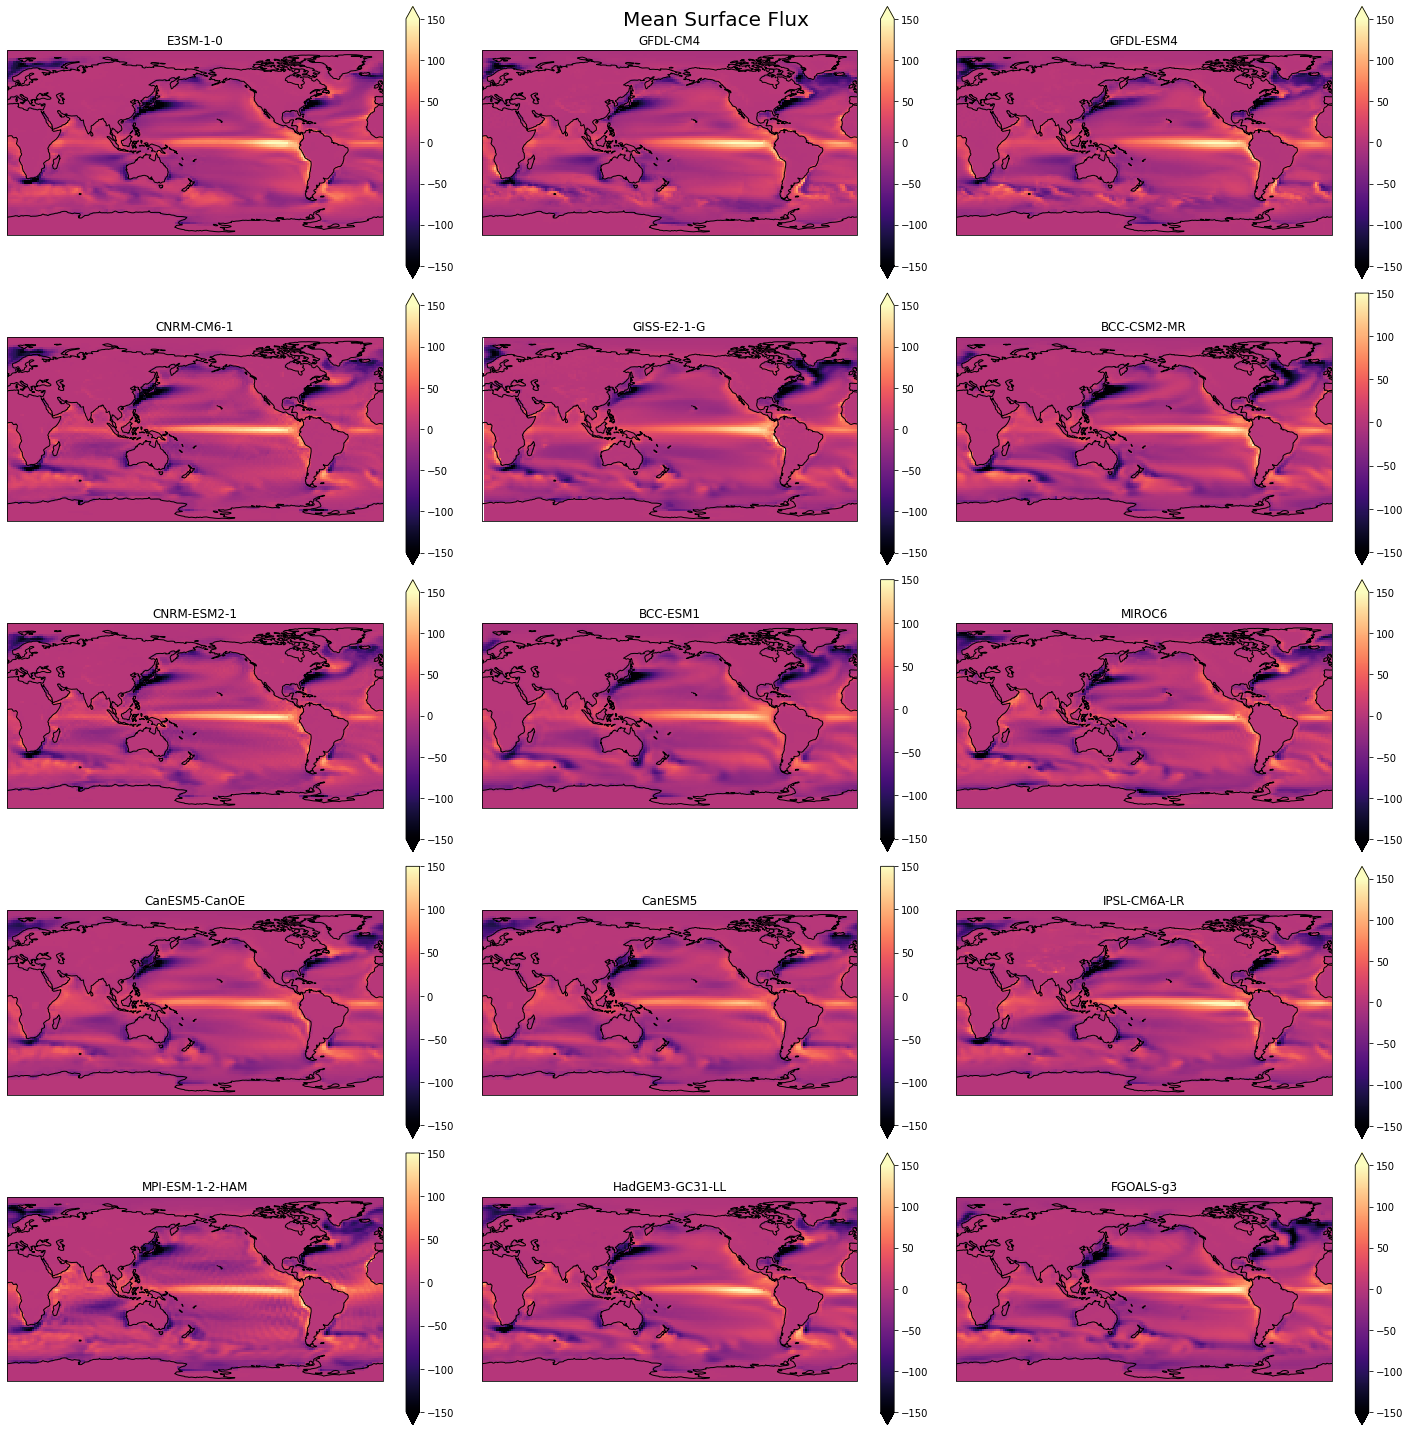

In [65]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in surface_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    surface_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-150, vmax=150, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean Surface Flux', fontsize=20, y=0.99)

Text(0.5, 0.99, 'Surface Flux Interdecadal Variability (>25 years)')

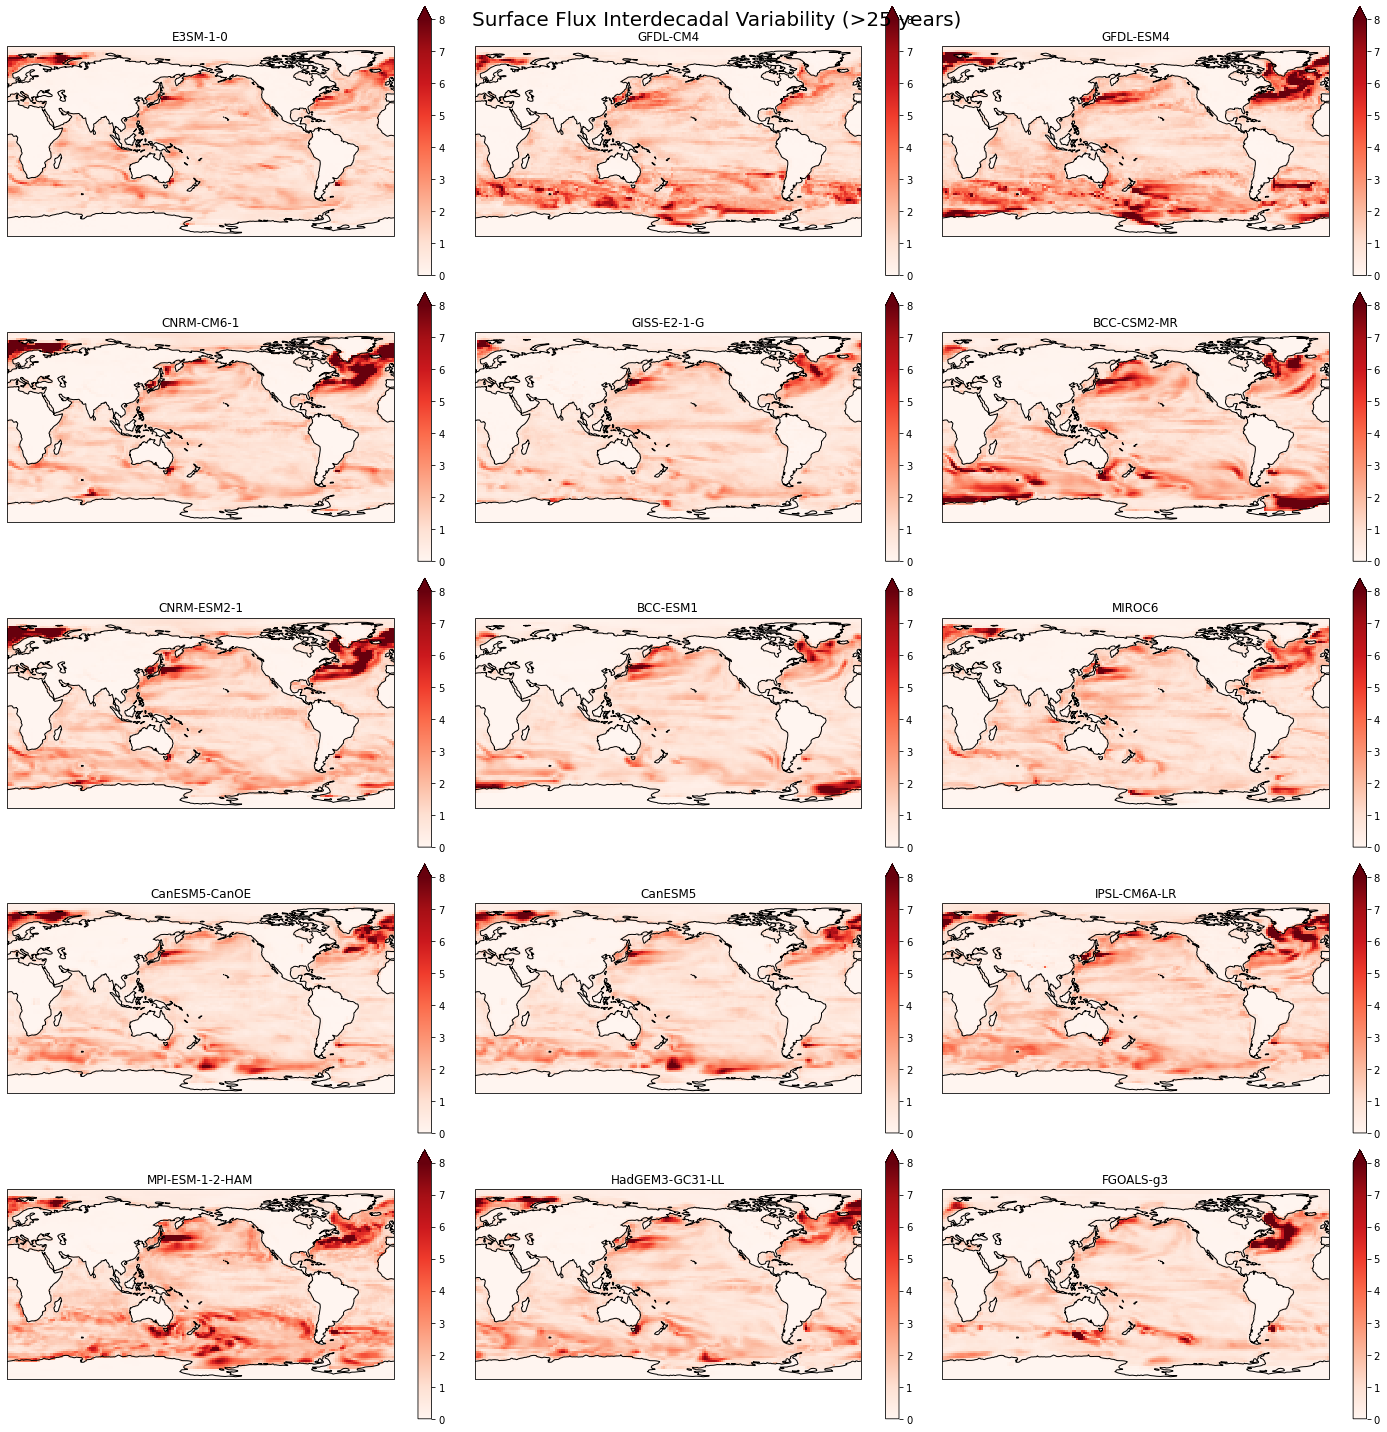

In [69]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in surface_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = surface_control.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=8, cmap='Reds')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Surface Flux Interdecadal Variability (>25 years)', fontsize=20, y=0.99)

In [70]:
surface_rolling = surface_control.rolling(time=300, center=True).mean('time')
surface_stand = surface_rolling.std('time')
surface_var = surface_stand.mean('name')

Text(0.5, 1.0, '25 year Surface Flux interdecadal variability (N=15)')

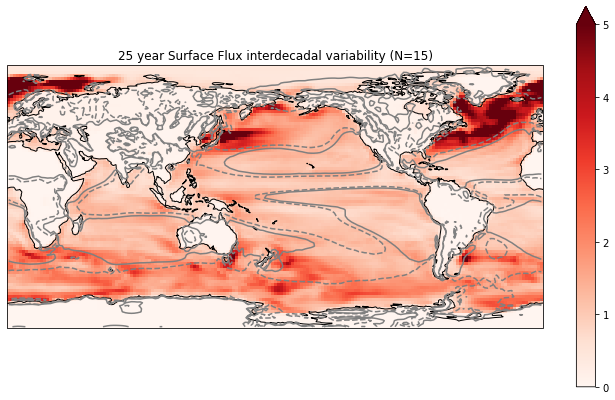

In [73]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
surface_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=5, cmap='Reds')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('25 year Surface Flux interdecadal variability (N=15)')

# TOA Fluxes

### rsdt  - toa downwelling shortwave flux

In [14]:
df_rsdt_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl'")
df_rsdt_control = df_rsdt_control.drop_duplicates('source_id').head(18)
df_rsdt_control = df_rsdt_control.drop(index=101)
df_rsdt_control = df_rsdt_control.drop(index=45940)
df_rsdt_control = df_rsdt_control.drop(index=55709)
df_rsdt_control = df_rsdt_control.drop(index=66851)
df_rsdt_control = df_rsdt_control.drop(index=67586)
df_rsdt_control = df_rsdt_control.drop(index=67728)
df_rsdt_control = df_rsdt_control.drop(index=72904)
df_rsdt_control = df_rsdt_control.drop(index=75720)

df_rsdt_control

activity_id institution_id      source_id experiment_id member_id  \
9347         CMIP      NOAA-GFDL       GFDL-CM4     piControl  r1i1p1f1   
18468        CMIP      NOAA-GFDL      GFDL-ESM4     piControl  r1i1p1f1   
31934        CMIP   CNRM-CERFACS     CNRM-CM6-1     piControl  r1i1p1f2   
32228        CMIP      NASA-GISS    GISS-E2-1-G     piControl  r1i1p1f1   
40406        CMIP            BCC    BCC-CSM2-MR     piControl  r1i1p1f1   
42789        CMIP   CNRM-CERFACS    CNRM-ESM2-1     piControl  r1i1p1f2   
44831        CMIP            BCC       BCC-ESM1     piControl  r1i1p1f1   
65324        CMIP          MIROC         MIROC6     piControl  r1i1p1f1   
88446        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   
89842        CMIP          CCCma        CanESM5     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9347      Amon        rsdt        gr1   
18468     Amon        rsdt        gr1   
31934     Amon        rsdt         gr   
32228     Amon        rsdt         gn   
40406     Amon        rsdt         gn   
42789     Amon        rsdt         gr   
44831     Amon        rsdt         gn   
65324     Amon        rsdt         gn   
88446     Amon        rsdt         gn   
89842     Amon        rsdt         gn   

                                                  zstore  dcpp_init_year  \
9347   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18468  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31934  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32228  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40406  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42789  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44831  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65324  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88446  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89842  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
9347   20180701  
18468  20180701  
31934  20180814  
32228  20180824  
40406  20181016  
42789  20181115  
44831  20181214  
65324  20190311  
88446  20190429  
89842  20190429

In [15]:
df_rsdt_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rsdt_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429100        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429100     Amon        rsdt         gr   

                                                   zstore  dcpp_init_year  \
429100  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429100  20200326

In [16]:
df_rsdt_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_rsdt_MPIESM

activity_id     institution_id        source_id experiment_id  \
212162        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
212162  r1i1p1f1     Amon        rsdt         gn   

                                                   zstore  dcpp_init_year  \
212162  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
212162  20190627

In [17]:
df_rsdt_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_rsdt_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
213476        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
213476     Amon        rsdt         gn   

                                                   zstore  dcpp_init_year  \
213476  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
213476  20190628

In [18]:
df_rsdt_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_rsdt_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243335        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243335        rsdt         gr   

                                                   zstore  dcpp_init_year  \
243335  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243335  20190719

In [19]:
df_rsdt_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rsdt_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254966        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254966        rsdt         gn   

                                                   zstore  dcpp_init_year  \
254966  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254966  20190818

In [20]:
df_rsdt_control = df_rsdt_control.append(df_rsdt_IPSL)
df_rsdt_control = df_rsdt_control.append(df_rsdt_HadGEM)
df_rsdt_control = df_rsdt_control.append(df_rsdt_E3SM)
df_rsdt_control = df_rsdt_control.append(df_rsdt_FGOALS)
df_rsdt_control = df_rsdt_control.append(df_rsdt_MPIESM)
df_rsdt_control

/tmp/ipykernel_15858/3248129763.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsdt_control = df_rsdt_control.append(df_rsdt_IPSL)
/tmp/ipykernel_15858/3248129763.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsdt_control = df_rsdt_control.append(df_rsdt_HadGEM)
/tmp/ipykernel_15858/3248129763.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsdt_control = df_rsdt_control.append(df_rsdt_E3SM)
/tmp/ipykernel_15858/3248129763.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsdt_control = df_rsdt_control.append(df_rsdt_FGOALS)
/tmp/ipykernel_15858/3248129763.py:5: FutureWarning: The frame.append method is depr

activity_id     institution_id        source_id experiment_id  \
9347          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18468         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31934         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32228         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40406         CMIP                BCC      BCC-CSM2-MR     piControl   
42789         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44831         CMIP                BCC         BCC-ESM1     piControl   
65324         CMIP              MIROC           MIROC6     piControl   
88446         CMIP              CCCma    CanESM5-CanOE     piControl   
89842         CMIP              CCCma          CanESM5     piControl   
429100        CMIP               IPSL     IPSL-CM6A-LR     piControl   
213476        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243335        CMIP       E3SM-Project         E3SM-1-0     piControl   
254966        CMIP                CAS        FGOALS-g3     piControl   
212162        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
9347    r1i1p1f1     Amon        rsdt        gr1   
18468   r1i1p1f1     Amon        rsdt        gr1   
31934   r1i1p1f2     Amon        rsdt         gr   
32228   r1i1p1f1     Amon        rsdt         gn   
40406   r1i1p1f1     Amon        rsdt         gn   
42789   r1i1p1f2     Amon        rsdt         gr   
44831   r1i1p1f1     Amon        rsdt         gn   
65324   r1i1p1f1     Amon        rsdt         gn   
88446   r1i1p2f1     Amon        rsdt         gn   
89842   r1i1p1f1     Amon        rsdt         gn   
429100  r1i1p1f1     Amon        rsdt         gr   
213476  r1i1p1f1     Amon        rsdt         gn   
243335  r1i1p1f1     Amon        rsdt         gr   
254966  r1i1p1f1     Amon        rsdt         gn   
212162  r1i1p1f1     Amon        rsdt         gn   

                                                   zstore  dcpp_init_year  \
9347    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18468   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31934   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32228   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40406   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42789   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44831   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65324   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88446   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89842   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
429100  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
213476  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243335  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
254966  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   
212162  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
9347    20180701  
18468   20180701  
31934   20180814  
32228   20180824  
40406   20181016  
42789   20181115  
44831   20181214  
65324   20190311  
88446   20190429  
89842   20190429  
429100  20200326  
213476  20190628  
243335  20190719  
254966  20190818  
212162  20190627

In [21]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rsdt = []
for zstore in df_rsdt_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rsdt_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rsdt = ds_rsdt_interp.rsdt
    ds_rsdt['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsdt.append(ds_rsdt)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


HadGEM3-GC31-LL
E3SM-1-0
FGOALS-g3
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

In [22]:
rsdt_control = xr.concat(dset_list_rsdt, dim='name', coords='minimal', compat='override')
rsdt_control.load()

<xarray.DataArray 'rsdt' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[4.95660434e+02, 4.95667151e+02, 4.95669731e+02, ...,
          4.95634009e+02, 4.95640556e+02, 4.95647127e+02],
         [4.94432652e+02, 4.94387912e+02, 4.94377220e+02, ...,
          4.94425299e+02, 4.94437714e+02, 4.94450168e+02],
         [4.92571230e+02, 4.92627934e+02, 4.92659630e+02, ...,
          4.92618604e+02, 4.92636749e+02, 4.92649646e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.07432571e+02, 3.07436722e+02, 3.07438309e+02, ...,
          3.07416206e+02, 3.07420250e+02, 3.07424329e+02],
         [3.06671159e+02, 3.06642950e+02, 3.06636032e+02, ...,
          3.06666910e+02, 3.06674599e+02, 3.06682323e+02],
         [3.05516884e+02, 3.05552000e+02, 3.05572601e+02, ...,
          3.05546722e+02, 3.05557976e+02, 3.05566000e+02],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[5.48719541e+02, 5.48719541e+02, 5.48719541e+02, ...,
          5.48719541e+02, 5.48719541e+02, 5.48719541e+02],
         [5.47394246e+02, 5.47394246e+02, 5.47394246e+02, ...,
          5.47394246e+02, 5.47394246e+02, 5.47394246e+02],
         [5.45407324e+02, 5.45407324e+02, 5.45407324e+02, ...,
          5.45407324e+02, 5.45407324e+02, 5.45407324e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'MPI-ESM-1-2-HAM'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      TOA Incident Shortwave Radiation
    original_name:  rsdt
    standard_name:  toa_incoming_shortwave_flux
    units:          W m-2

In [13]:
rsdt_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rsdt_piControl_2x2_250yr.nc')

### rsut - shortwave upwards toa flux 

In [23]:
df_rsut_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl'")
df_rsut_control = df_rsut_control.drop_duplicates('source_id').head(16)
df_rsut_control = df_rsut_control.drop(index=45950)
df_rsut_control = df_rsut_control.drop(index=55662)
df_rsut_control = df_rsut_control.drop(index=66853)
df_rsut_control = df_rsut_control.drop(index=67550)
df_rsut_control = df_rsut_control.drop(index=67755)
df_rsut_control = df_rsut_control.drop(index=75723)
df_rsut_control

activity_id institution_id      source_id experiment_id member_id  \
9405         CMIP      NOAA-GFDL       GFDL-CM4     piControl  r1i1p1f1   
18487        CMIP      NOAA-GFDL      GFDL-ESM4     piControl  r1i1p1f1   
31929        CMIP   CNRM-CERFACS     CNRM-CM6-1     piControl  r1i1p1f2   
32239        CMIP      NASA-GISS    GISS-E2-1-G     piControl  r1i1p1f1   
40411        CMIP            BCC    BCC-CSM2-MR     piControl  r1i1p1f1   
42787        CMIP   CNRM-CERFACS    CNRM-ESM2-1     piControl  r1i1p1f2   
44877        CMIP            BCC       BCC-ESM1     piControl  r1i1p1f1   
65290        CMIP          MIROC         MIROC6     piControl  r1i1p1f1   
88448        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   
89818        CMIP          CCCma        CanESM5     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9405      Amon        rsut        gr1   
18487     Amon        rsut        gr1   
31929     Amon        rsut         gr   
32239     Amon        rsut         gn   
40411     Amon        rsut         gn   
42787     Amon        rsut         gr   
44877     Amon        rsut         gn   
65290     Amon        rsut         gn   
88448     Amon        rsut         gn   
89818     Amon        rsut         gn   

                                                  zstore  dcpp_init_year  \
9405   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18487  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31929  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32239  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40411  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42787  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44877  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65290  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88448  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89818  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
9405   20180701  
18487  20180701  
31929  20180814  
32239  20180824  
40411  20181016  
42787  20181115  
44877  20181214  
65290  20190311  
88448  20190429  
89818  20190429

In [24]:
df_rsut_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rsut_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429118        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429118     Amon        rsut         gr   

                                                   zstore  dcpp_init_year  \
429118  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429118  20200326

In [25]:
df_rsut_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_rsut_MPIESM

activity_id     institution_id        source_id experiment_id  \
211880        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
211880  r1i1p1f1     Amon        rsut         gn   

                                                   zstore  dcpp_init_year  \
211880  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
211880  20190627

In [26]:
df_rsut_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_rsut_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
213479        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
213479     Amon        rsut         gn   

                                                   zstore  dcpp_init_year  \
213479  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
213479  20190628

In [27]:
df_rsut_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_rsut_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243308        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243308        rsut         gr   

                                                   zstore  dcpp_init_year  \
243308  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243308  20190719

In [28]:
df_rsut_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rsut_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254881        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254881        rsut         gn   

                                                   zstore  dcpp_init_year  \
254881  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254881  20190818

In [29]:
df_rsut_control = df_rsut_control.append(df_rsut_IPSL)
df_rsut_control = df_rsut_control.append(df_rsut_MPIESM)
df_rsut_control = df_rsut_control.append(df_rsut_HadGEM)
df_rsut_control = df_rsut_control.append(df_rsut_E3SM)
df_rsut_control = df_rsut_control.append(df_rsut_FGOALS)
df_rsut_control

/tmp/ipykernel_15858/1745248407.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsut_control = df_rsut_control.append(df_rsut_IPSL)
/tmp/ipykernel_15858/1745248407.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsut_control = df_rsut_control.append(df_rsut_MPIESM)
/tmp/ipykernel_15858/1745248407.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsut_control = df_rsut_control.append(df_rsut_HadGEM)
/tmp/ipykernel_15858/1745248407.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rsut_control = df_rsut_control.append(df_rsut_E3SM)
/tmp/ipykernel_15858/1745248407.py:5: FutureWarning: The frame.append method is depr

activity_id     institution_id        source_id experiment_id  \
9405          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18487         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31929         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32239         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40411         CMIP                BCC      BCC-CSM2-MR     piControl   
42787         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44877         CMIP                BCC         BCC-ESM1     piControl   
65290         CMIP              MIROC           MIROC6     piControl   
88448         CMIP              CCCma    CanESM5-CanOE     piControl   
89818         CMIP              CCCma          CanESM5     piControl   
429118        CMIP               IPSL     IPSL-CM6A-LR     piControl   
211880        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213479        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243308        CMIP       E3SM-Project         E3SM-1-0     piControl   
254881        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9405    r1i1p1f1     Amon        rsut        gr1   
18487   r1i1p1f1     Amon        rsut        gr1   
31929   r1i1p1f2     Amon        rsut         gr   
32239   r1i1p1f1     Amon        rsut         gn   
40411   r1i1p1f1     Amon        rsut         gn   
42787   r1i1p1f2     Amon        rsut         gr   
44877   r1i1p1f1     Amon        rsut         gn   
65290   r1i1p1f1     Amon        rsut         gn   
88448   r1i1p2f1     Amon        rsut         gn   
89818   r1i1p1f1     Amon        rsut         gn   
429118  r1i1p1f1     Amon        rsut         gr   
211880  r1i1p1f1     Amon        rsut         gn   
213479  r1i1p1f1     Amon        rsut         gn   
243308  r1i1p1f1     Amon        rsut         gr   
254881  r1i1p1f1     Amon        rsut         gn   

                                                   zstore  dcpp_init_year  \
9405    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18487   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31929   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32239   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40411   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42787   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44877   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
65290   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
88448   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89818   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
429118  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
211880  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213479  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243308  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
254881  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9405    20180701  
18487   20180701  
31929   20180814  
32239   20180824  
40411   20181016  
42787   20181115  
44877   20181214  
65290   20190311  
88448   20190429  
89818   20190429  
429118  20200326  
211880  20190627  
213479  20190628  
243308  20190719  
254881  20190818

In [30]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rsut = []
for zstore in df_rsut_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rsut_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rsut = ds_rsut_interp.rsut
    ds_rsut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsut.append(ds_rsut)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CanESM5-CanOE
CanESM5
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
FGOALS-g3


In [31]:
rsut_control = xr.concat(dset_list_rsut, dim='name', coords='minimal', compat='override')
rsut_control.load()

<xarray.DataArray 'rsut' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[3.49139517e+02, 3.49143633e+02, 3.49156967e+02, ...,
          3.49123315e+02, 3.49127319e+02, 3.49131358e+02],
         [3.48629478e+02, 3.48295580e+02, 3.48160027e+02, ...,
          3.48705544e+02, 3.48714462e+02, 3.48723415e+02],
         [3.45271222e+02, 3.45374223e+02, 3.45464676e+02, ...,
          3.44936153e+02, 3.44978790e+02, 3.45041782e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.17120991e+02, 2.17131699e+02, 2.17151802e+02, ...,
          2.17078928e+02, 2.17089329e+02, 2.17099802e+02],
         [2.16271617e+02, 2.16201051e+02, 2.16186043e+02, ...,
          2.16194737e+02, 2.16204823e+02, 2.16214944e+02],
         [2.14094942e+02, 2.14171217e+02, 2.14290939e+02, ...,
          2.13720073e+02, 2.13748055e+02, 2.13792895e+02],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.95758981e+02, 3.95009583e+02, 3.95888125e+02, ...,
          3.95623451e+02, 3.94479124e+02, 3.95552662e+02],
         [3.95777176e+02, 3.94529196e+02, 3.95993045e+02, ...,
          3.95552045e+02, 3.93645271e+02, 3.95434206e+02],
         [3.92362861e+02, 3.92617686e+02, 3.93999112e+02, ...,
          3.91848400e+02, 3.91269357e+02, 3.93325122e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'E3SM-1-0' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      TOA Outgoing Shortwave Radiation
    original_name:  rsut
    standard_name:  toa_outgoing_shortwave_flux
    units:          W m-2

In [23]:
rsut_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rsut_piControl_2x2_250yr.nc')

### rlut - upwards longwave top of atmosphere radiation

In [4]:
df_rlut_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl'")
df_rlut_control = df_rlut_control.drop_duplicates('source_id').head(15)
df_rlut_control = df_rlut_control.drop(index=55745)
df_rlut_control = df_rlut_control.drop(index=66848)
df_rlut_control = df_rlut_control.drop(index=67721)
df_rlut_control = df_rlut_control.drop(index=67750)
df_rlut_control = df_rlut_control.drop(index=76030)
df_rlut_control

activity_id institution_id      source_id experiment_id member_id  \
9351         CMIP      NOAA-GFDL       GFDL-CM4     piControl  r1i1p1f1   
18479        CMIP      NOAA-GFDL      GFDL-ESM4     piControl  r1i1p1f1   
31925        CMIP   CNRM-CERFACS     CNRM-CM6-1     piControl  r1i1p1f2   
32225        CMIP      NASA-GISS    GISS-E2-1-G     piControl  r1i1p1f1   
40401        CMIP            BCC    BCC-CSM2-MR     piControl  r1i1p1f1   
42802        CMIP   CNRM-CERFACS    CNRM-ESM2-1     piControl  r1i1p1f2   
44325        CMIP          MIROC         MIROC6     piControl  r1i1p1f1   
44835        CMIP            BCC       BCC-ESM1     piControl  r1i1p1f1   
88443        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   
89847        CMIP          CCCma        CanESM5     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9351      Amon        rlut        gr1   
18479     Amon        rlut        gr1   
31925     Amon        rlut         gr   
32225     Amon        rlut         gn   
40401     Amon        rlut         gn   
42802     Amon        rlut         gr   
44325     Amon        rlut         gn   
44835     Amon        rlut         gn   
88443     Amon        rlut         gn   
89847     Amon        rlut         gn   

                                                  zstore  dcpp_init_year  \
9351   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18479  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31925  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32225  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40401  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42802  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44325  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
44835  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
88443  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89847  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
9351   20180701  
18479  20180701  
31925  20180814  
32225  20180824  
40401  20181016  
42802  20181115  
44325  20181212  
44835  20181214  
88443  20190429  
89847  20190429

In [5]:
df_rlut_IPSL = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_rlut_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429092        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429092     Amon        rlut         gr   

                                                   zstore  dcpp_init_year  \
429092  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429092  20200326

In [6]:
df_rlut_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_rlut_MPIESM

activity_id     institution_id        source_id experiment_id  \
407405        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
407405  r1i1p1f1     Amon        rlut         gn   

                                                   zstore  dcpp_init_year  \
407405  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
407405  20200120

In [7]:
df_rlut_HadGEM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_rlut_HadGEM

activity_id institution_id        source_id experiment_id member_id  \
523704        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
523704     Amon        rlut         gn   

                                                   zstore  dcpp_init_year  \
523704  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
523704  20211103

In [8]:
df_rlut_E3SM = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_rlut_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
243345        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
243345        rlut         gr   

                                                   zstore  dcpp_init_year  \
243345  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
243345  20190719

In [9]:
df_rlut_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_rlut_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
254953        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254953        rlut         gn   

                                                   zstore  dcpp_init_year  \
254953  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254953  20190818

In [10]:
df_rlut_control = df_rlut_control.append(df_rlut_IPSL)
df_rlut_control = df_rlut_control.append(df_rlut_MPIESM)
df_rlut_control = df_rlut_control.append(df_rlut_HadGEM)
df_rlut_control = df_rlut_control.append(df_rlut_E3SM)
df_rlut_control = df_rlut_control.append(df_rlut_FGOALS)
df_rlut_control

/tmp/ipykernel_15858/3161117467.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlut_control = df_rlut_control.append(df_rlut_IPSL)
/tmp/ipykernel_15858/3161117467.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlut_control = df_rlut_control.append(df_rlut_MPIESM)
/tmp/ipykernel_15858/3161117467.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlut_control = df_rlut_control.append(df_rlut_HadGEM)
/tmp/ipykernel_15858/3161117467.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rlut_control = df_rlut_control.append(df_rlut_E3SM)
/tmp/ipykernel_15858/3161117467.py:5: FutureWarning: The frame.append method is depr

activity_id     institution_id        source_id experiment_id  \
9351          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18479         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31925         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32225         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40401         CMIP                BCC      BCC-CSM2-MR     piControl   
42802         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44325         CMIP              MIROC           MIROC6     piControl   
44835         CMIP                BCC         BCC-ESM1     piControl   
88443         CMIP              CCCma    CanESM5-CanOE     piControl   
89847         CMIP              CCCma          CanESM5     piControl   
429092        CMIP               IPSL     IPSL-CM6A-LR     piControl   
407405        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
523704        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243345        CMIP       E3SM-Project         E3SM-1-0     piControl   
254953        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9351    r1i1p1f1     Amon        rlut        gr1   
18479   r1i1p1f1     Amon        rlut        gr1   
31925   r1i1p1f2     Amon        rlut         gr   
32225   r1i1p1f1     Amon        rlut         gn   
40401   r1i1p1f1     Amon        rlut         gn   
42802   r1i1p1f2     Amon        rlut         gr   
44325   r1i1p1f1     Amon        rlut         gn   
44835   r1i1p1f1     Amon        rlut         gn   
88443   r1i1p2f1     Amon        rlut         gn   
89847   r1i1p1f1     Amon        rlut         gn   
429092  r1i1p1f1     Amon        rlut         gr   
407405  r1i1p1f1     Amon        rlut         gn   
523704  r1i1p1f1     Amon        rlut         gn   
243345  r1i1p1f1     Amon        rlut         gr   
254953  r1i1p1f1     Amon        rlut         gn   

                                                   zstore  dcpp_init_year  \
9351    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18479   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31925   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32225   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40401   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42802   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44325   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
44835   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
88443   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89847   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
429092  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
407405  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
523704  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243345  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
254953  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9351    20180701  
18479   20180701  
31925   20180814  
32225   20180824  
40401   20181016  
42802   20181115  
44325   20181212  
44835   20181214  
88443   20190429  
89847   20190429  
429092  20200326  
407405  20200120  
523704  20211103  
243345  20190719  
254953  20190818

In [11]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_rlut = []
for zstore in df_rlut_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_rlut_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_rlut = ds_rlut_interp.rlut
    ds_rlut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlut.append(ds_rlut)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


BCC-ESM1
CanESM5-CanOE
CanESM5
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
FGOALS-g3


In [12]:
rlut_control = xr.concat(dset_list_rlut, dim='name', coords='minimal', compat='override')
rlut_control.load()

<xarray.DataArray 'rlut' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[184.11755295, 183.92163391, 183.73286057, ..., 184.90343857,
          184.70664597, 184.51005478],
         [184.4378273 , 184.16784134, 184.01701355, ..., 186.13247452,
          185.7055397 , 185.27997818],
         [188.29533157, 187.77252197, 187.24480057, ..., 190.2708847 ,
          189.72491837, 189.19615784],
         ...,
         [164.93603287, 165.41471939, 165.81769562, ..., 161.88671417,
          162.31818771, 162.80013428],
         [162.37325897, 162.7618721 , 162.92761612, ..., 161.0426796 ,
          161.30862427, 161.57202301],
         [159.14250946, 159.21314545, 159.28797913, ..., 158.8551384 ,
          158.92768097, 158.99979019]],

        [[164.94500275, 164.66819458, 164.42263412, ..., 166.06075821,
          165.78057098, 165.50116348],
         [166.79160767, 166.15215073, 165.83843231, ..., 169.54057693,
          168.85323334, 168.16897354],
         [171.51562958, 170.65734024, 169.78134155, ..., 175.63249664,
          174.57402802, 173.53178864],
...
         [156.29963222, 156.60068909, 156.95141654, ..., 155.20303343,
          155.48704792, 155.76115717],
         [153.96128512, 154.1261293 , 154.10124521, ..., 152.51821368,
          152.87502186, 153.18369734],
         [152.08411665, 152.19769906, 152.18986395, ..., 151.21063219,
          151.42100006, 151.59984243]],

        [[167.98130408, 167.91832761, 167.48707883, ..., 169.35618596,
          169.22435287, 168.63751883],
         [169.85204937, 169.74684953, 169.02816259, ..., 172.14321399,
          171.92338536, 170.94545578],
         [172.67375625, 171.87960081, 170.78606618, ..., 175.99463363,
          175.09866536, 173.85789809],
         ...,
         [151.50508286, 151.71895965, 151.93980346, ..., 150.8628458 ,
          151.0013525 , 151.08865532],
         [149.70359307, 149.83523036, 149.7768656 , ..., 148.78670386,
          148.79117335, 149.02917812],
         [146.76055916, 146.82581473, 146.76669309, ..., 146.23069541,
          146.22900088, 146.36143693]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'E3SM-1-0' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      TOA Outgoing Longwave Radiation
    original_name:  rlut
    standard_name:  toa_outgoing_longwave_flux
    units:          W m-2

In [13]:
rlut_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_rlut_piControl_2x2_250yr.nc')

## TOA Total Flux

In [32]:
toa_control = rsdt_control - rlut_control - rsut_control

In [33]:
toa_control

<xarray.DataArray (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[ -37.5966362 ,  -37.39811554,  -37.22009659, ...,
           -38.39274521,  -38.19340897,  -37.99428635],
         [ -38.63465347,  -38.07550888,  -37.79981995, ...,
           -40.41271896,  -39.98228836,  -39.55322495],
         [ -40.99532394,  -40.51881104,  -40.04984665, ...,
           -42.58843384,  -42.06695938,  -41.58829346],
         ...,
         [-164.93603287, -165.41471939, -165.81769562, ...,
          -161.88671417, -162.31818771, -162.80013428],
         [-162.37325897, -162.7618721 , -162.92761612, ...,
          -161.0426796 , -161.30862427, -161.57202301],
         [-159.14250946, -159.21314545, -159.28797913, ...,
          -158.8551384 , -158.92768097, -158.99979019]],

        [[ -74.63342209,  -74.36317215,  -74.13612747, ...,
           -75.72348022,  -75.44964981,  -75.17663727],
         [ -76.39206543,  -75.71025085,  -75.38844299, ...,
           -79.06840439,  -78.38345718,  -77.70159531],
         [ -80.0936882 ,  -79.27655716,  -78.49967957, ...,
           -83.80584717,  -82.76410675,  -81.75868301],
...
         [-182.74431686, -183.12256366, -183.49586239, ...,
          -181.3035282 , -181.73445875, -182.16722273],
         [-180.91750836, -181.0566553 , -181.19621589, ...,
          -179.65352342, -179.9912132 , -180.33667707],
         [-178.18384932, -178.36246742, -178.60790811, ...,
          -177.16533445, -177.56729485, -177.84208259]],

        [[ -16.92775308,  -16.76632215,  -16.64895349, ...,
           -17.40677382,  -17.29627962,  -17.17815533],
         [ -18.0716832 ,  -17.93940529,  -17.7937281 , ...,
           -18.68773904,  -18.50398942,  -18.38610641],
         [ -21.31057692,  -20.96434643,  -20.39895932, ...,
           -22.49333251,  -22.15487576,  -21.86799305],
         ...,
         [-174.91959651, -175.24708233, -175.73080542, ...,
          -173.67796501, -173.91224178, -174.25276766],
         [-174.69469535, -174.80492462, -175.03274098, ...,
          -174.01133352, -174.06626184, -174.22247741],
         [-172.88174739, -172.87945575, -172.80862387, ...,
          -172.68603211, -172.66806408, -172.70043388]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'MPI-ESM-1-2-HAM'

In [34]:
toa_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_toa_piControl_2x2_250yr.nc')

Text(0.5, 0.99, 'Mean TOA Flux')

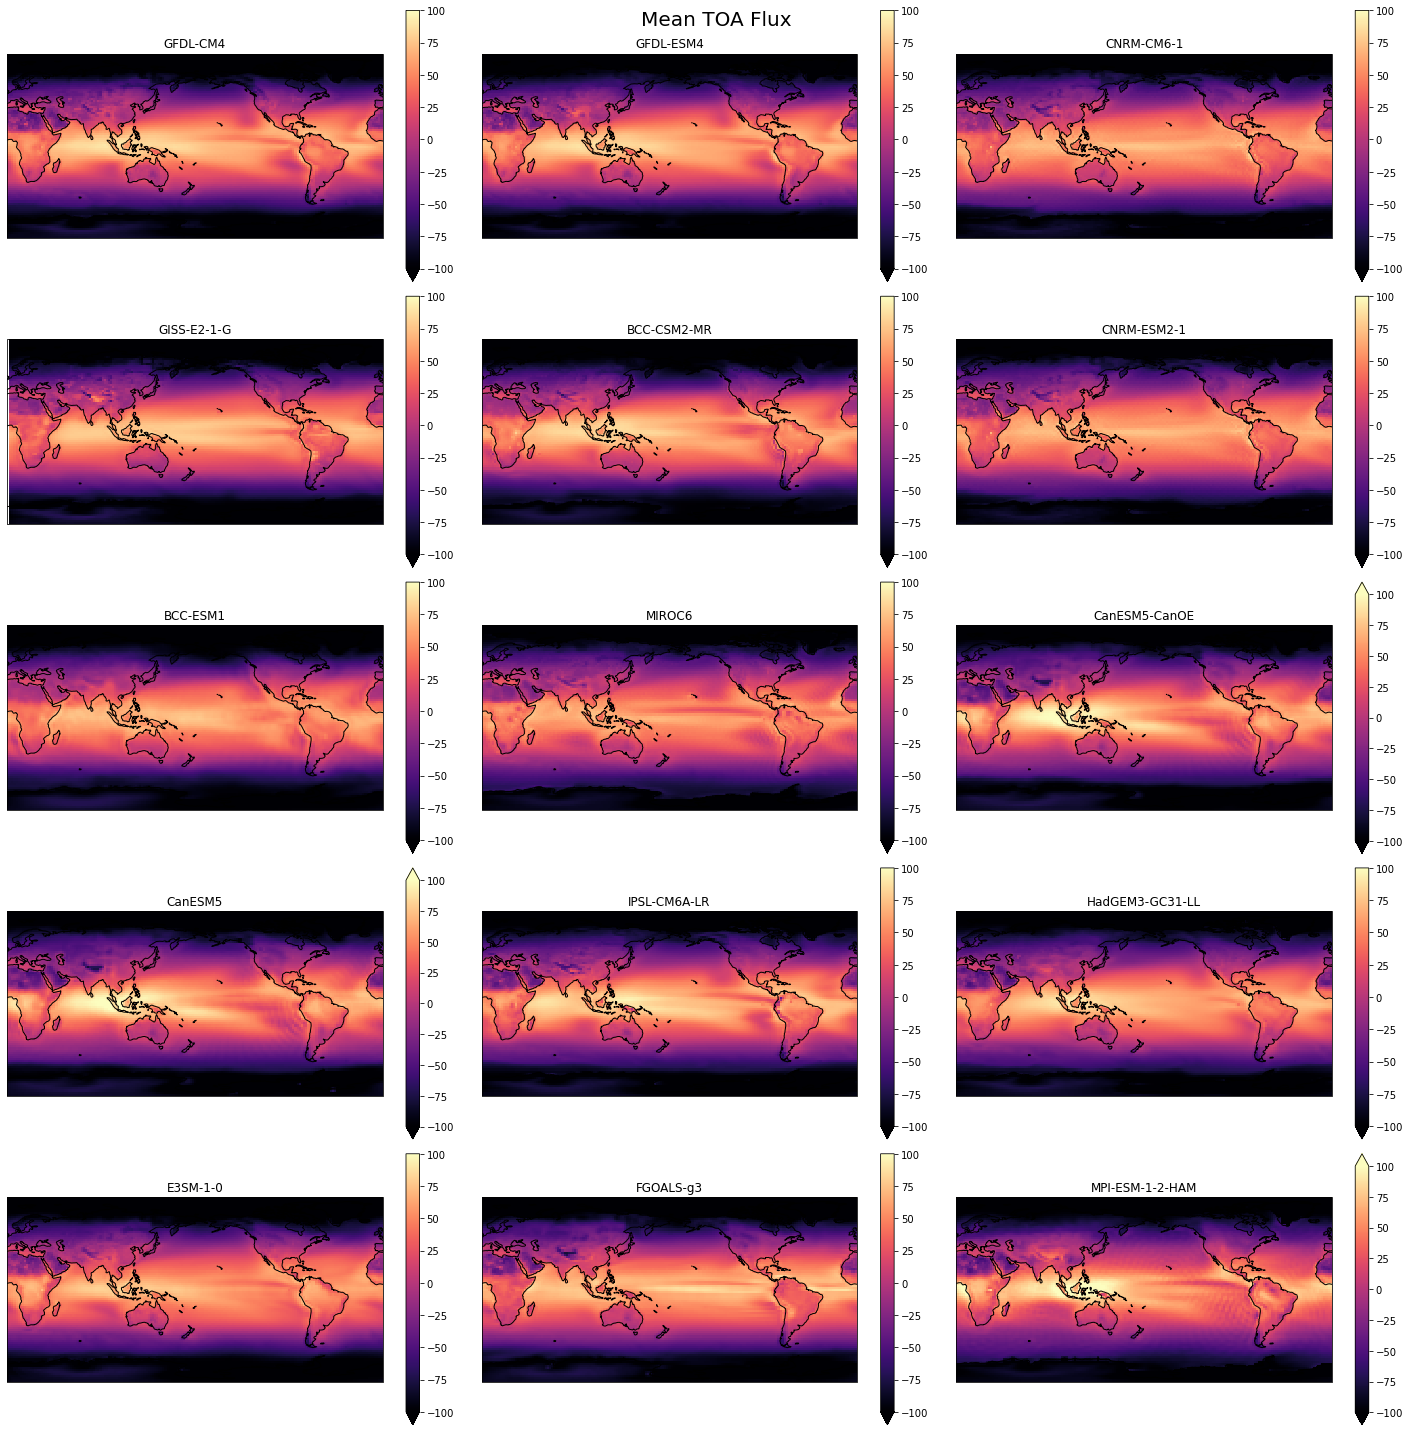

In [36]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in toa_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    toa_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean TOA Flux', fontsize=20, y=0.99)

Text(0.5, 0.99, 'TOA Flux Interdecadal Variability (>25 years)')

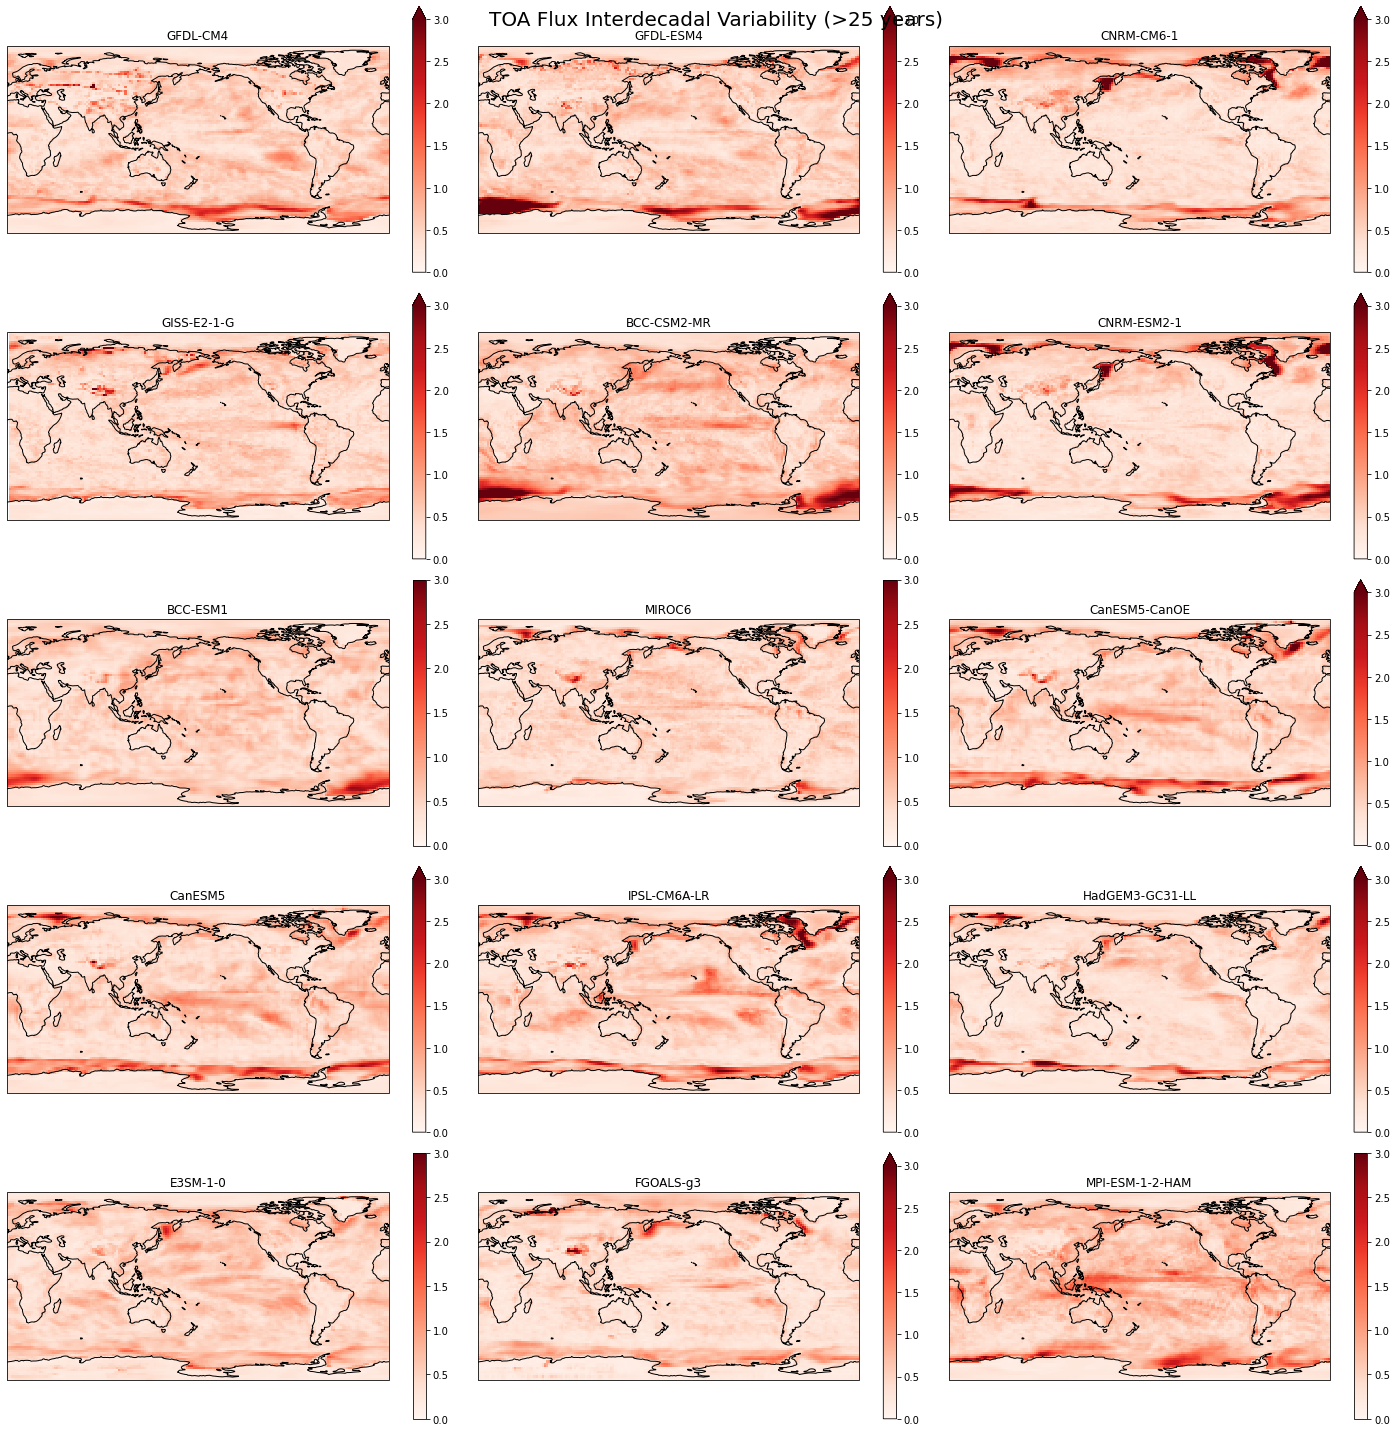

In [43]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in toa_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = toa_control.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=3, cmap='Reds')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('TOA Flux Interdecadal Variability (>25 years)', fontsize=20, y=0.99)

In [38]:
toa_rolling = toa_control.rolling(time=300, center=True).mean('time')
toa_stand = toa_rolling.std('time')
toa_var = toa_stand.mean('name')

Text(0.5, 1.0, '25 year TOA Flux interdecadal variability (N=15)')

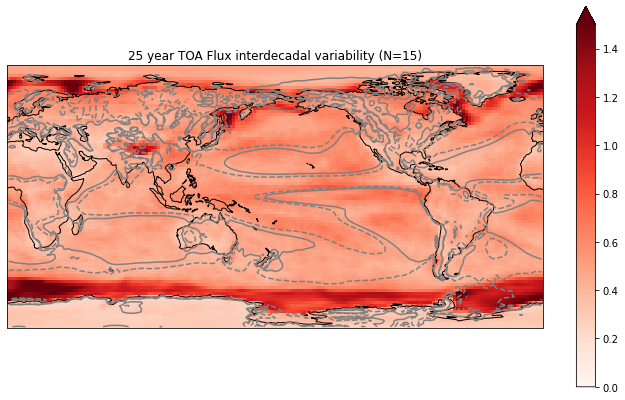

In [45]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
toa_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=1.5, cmap='Reds')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('25 year TOA Flux interdecadal variability (N=15)')

## Horizontal Flux

In [47]:
horiz_control = surface_control - toa_control

In [58]:
horiz_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_horiz_piControl_2x2_250yr.nc')

Text(0.5, 0.99, 'Mean Horiz Flux')

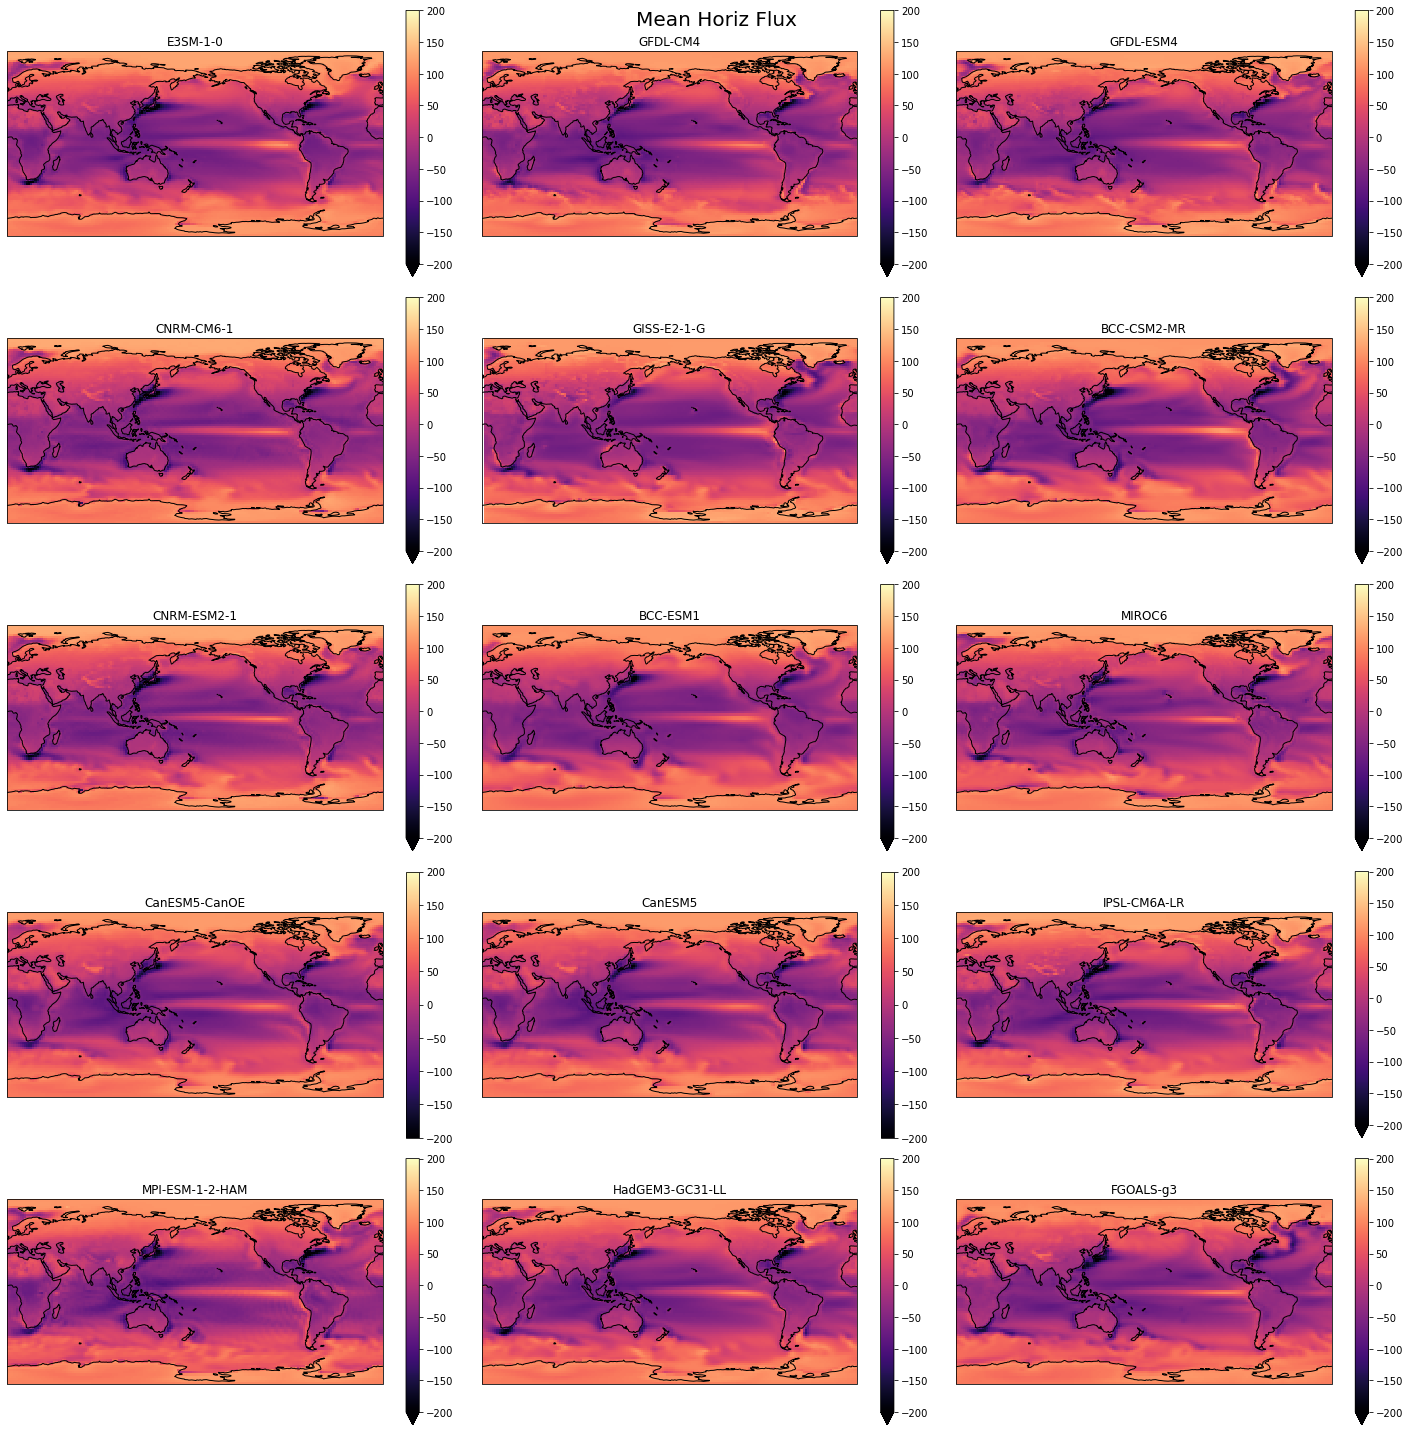

In [50]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in horiz_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    horiz_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='magma', vmin=-200, vmax=200)
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean Horiz Flux', fontsize=20, y=0.99)

Text(0.5, 0.99, 'Horiz. Flux Interdecadal Variability (>25 years)')

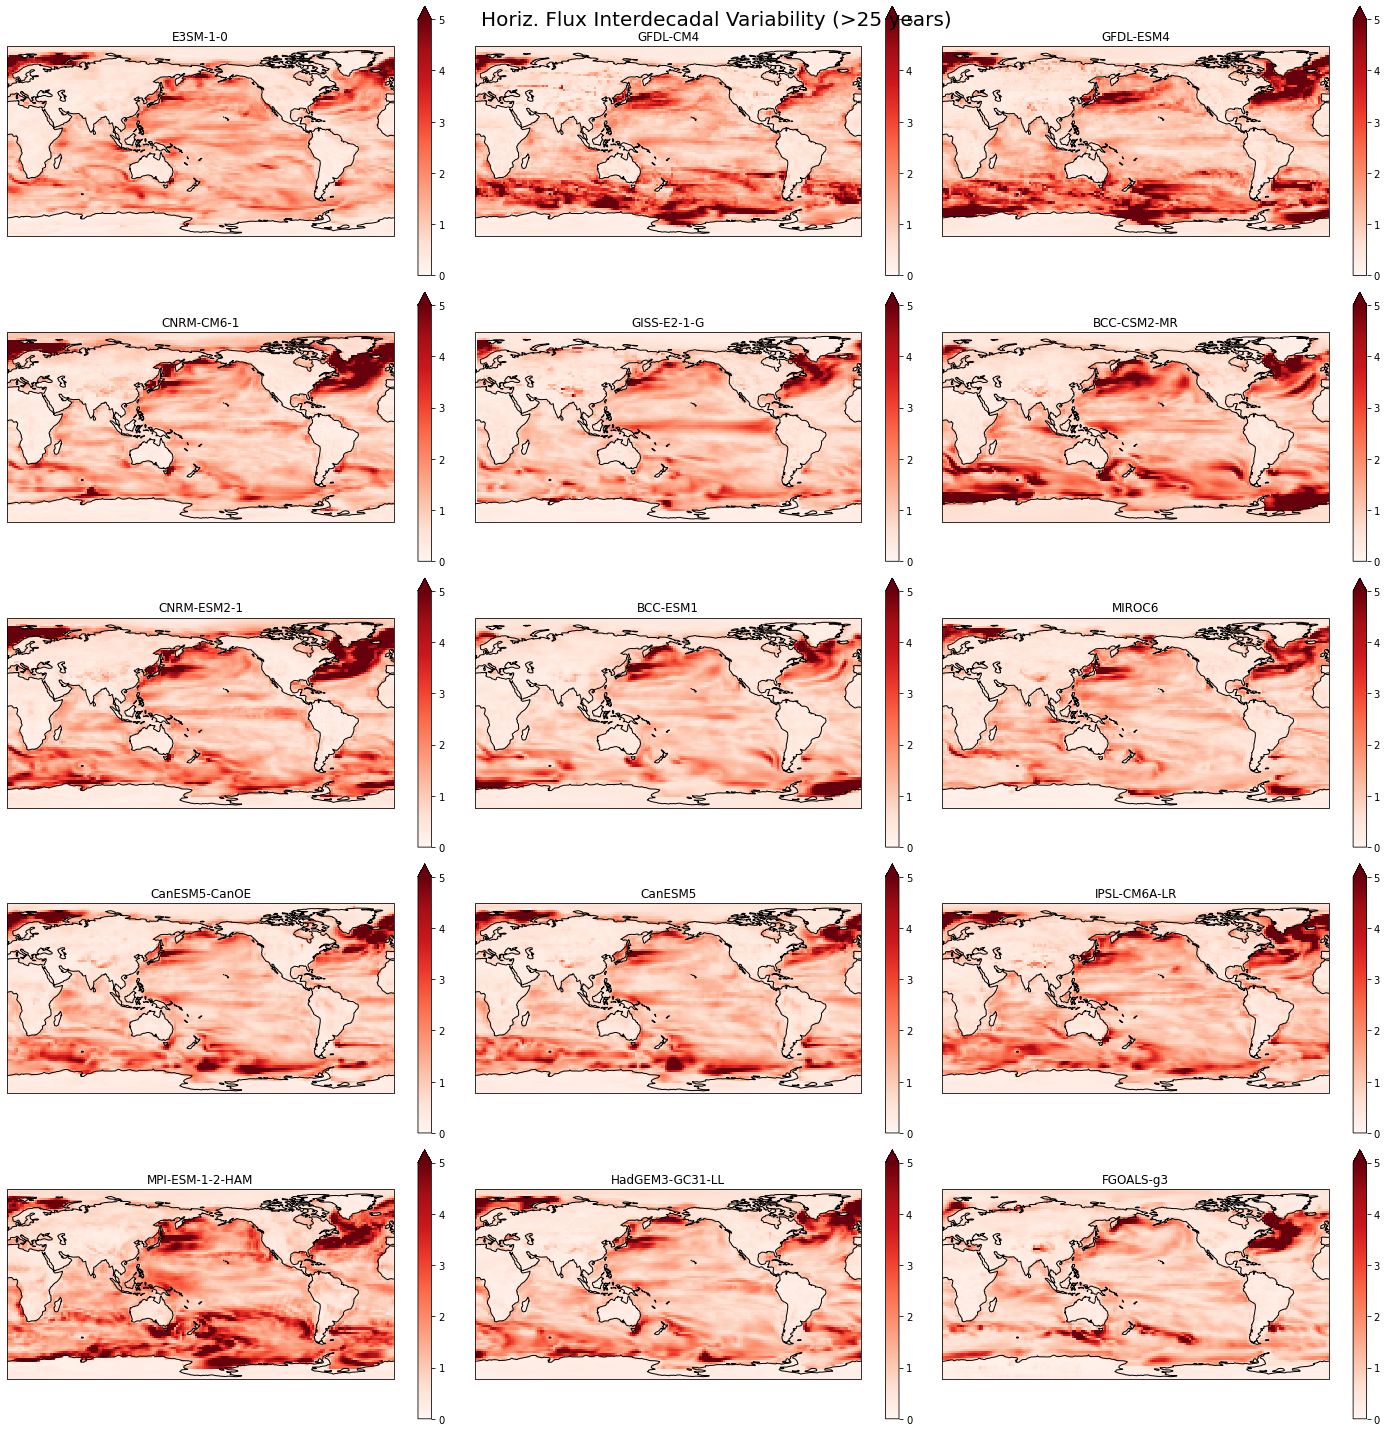

In [55]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in horiz_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = horiz_control.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=5)
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Horiz. Flux Interdecadal Variability (>25 years)', fontsize=20, y=0.99)

In [53]:
horiz_rolling = horiz_control.rolling(time=300, center=True).mean('time')
horiz_stand = horiz_rolling.std('time')
horiz_var = horiz_stand.mean('name')

Text(0.5, 1.0, '25 year Horiz. Flux interdecadal variability (N=15)')

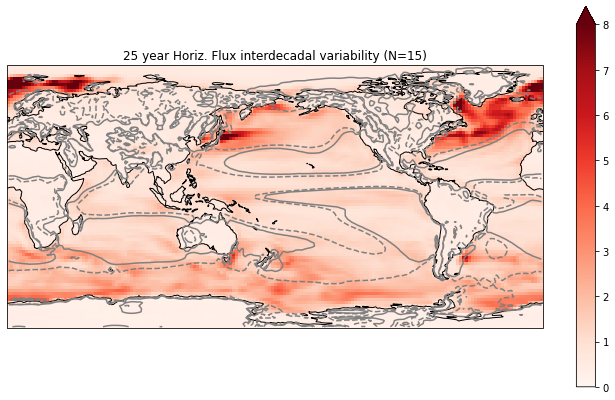

In [57]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
horiz_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=8, cmap='Reds')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('25 year Horiz. Flux interdecadal variability (N=15)')